# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
111558,69687092,Application Support ACCESS,Application Support Specialist required ACCES...,Tadworth,Tadworth,NaN,permanent,Modis International Limited,IT Jobs,54k pa + benefits,54000,jobsite.co.uk,10.896758
158690,71148580,General Manager Tenterden Cafe Rouge,General Manager Cafe Rouge Tenterden Cafe Ro...,"Tenterden, Kent, UK, Kent",Tenterden,NaN,NaN,Cafe Rouge,Hospitality & Catering Jobs,24k to 26k per year GBP,25000,jobs.catererandhotelkeeper.com,10.126671
19809,67106155,Class 1 HGV Drivers,Smart Recruitment is currently seeking **** Cl...,Mansfield,Mansfield,full_time,NaN,NaN,Logistics & Warehouse Jobs,8.00 - 12.00 per hour,19200,Jobcentre Plus,9.862718


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [ ]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [ ]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for text in data['Title']:
    token_counts.update(text.split())
for text in data['FullDescription']:
    token_counts.update(text.split())

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

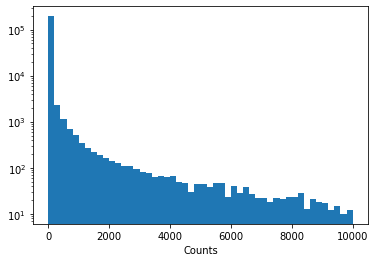

In [ ]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = []
for key in token_counts:
  if token_counts[key] > min_count:
    tokens.append(key)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 32456
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
token_id = [int(i) for i in range(len(tokens))]
token_to_id = dict(zip(tokens, token_id))

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 996  176    1    1    1]
 [  18 3461  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [ ]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)

    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)

    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch

In [ ]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[ 120,  291,   88,    1,    1,    1],
        [1006,  132,  119, 1610,    1,    1],
        [1852, 1345, 1919,   73, 1498, 5933]], dtype=int32),
 'FullDescription': array([[   49,  1613,    86,  2684,   561,  2620,  1584,   352,     9,
          1598],
        [ 1532, 11543,   558,   559,  5750,    73,   561,   304,  4308,
            57],
        [  561,   281,   168,  1604,  1593,  1562,  2490,  1429,  1613,
            73]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([10.434145,  9.609117,  9.998843], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim

    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.relu1 = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)

        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.relu1(h)
        h = self.dense(h)
        return h

In [ ]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [ ]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 128, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(128, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.relu1 = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        print(text_ix.shape)
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)

        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.relu1(h)
        h = self.dense(h)
        return h

In [ ]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

torch.Size([3, 604])
Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [ ]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """

    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()

        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)

        # define layers for categorical features. A few dense layers would do.


        self.categorical_features = nn.Linear(n_cat_features, n_cat_features)

        # define "output" layers that process depend the three encoded vectors into answer

        self.output_layers = nn.Linear(64 + 64 + n_cat_features, 1)

    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """

        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)

        # apply categorical encoder
        cat_h = self.categorical_features(cat_features)

        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)

        # ... and stack a few more layers at the top

        out = self.output_layers(joint_h)[:, 0]

        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.

        return out

In [ ]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

torch.Size([32, 621])


In [ ]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [ ]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [ ]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]

    irange = tnrange if verbose else range

    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [ ]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [ ]:
for epoch_i in range(num_epochs):

    print("Training:")
    train_loss = train_mae = train_batches = 0
    model.train(True)

    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1

    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')

    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)

    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


<ipython-input-39-d97ae8b50ffd>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 941])
torch.Size([32, 624])
torch.Size([32, 535])
torch.Size([32, 603])
torch.Size([32, 763])
torch.Size([32, 615])
torch.Size([32, 571])
torch.Size([32, 583])
torch.Size([32, 650])
torch.Size([32, 662])
torch.Size([32, 555])
torch.Size([32, 573])
torch.Size([32, 674])
torch.Size([32, 850])
torch.Size([32, 813])
torch.Size([32, 721])
torch.Size([32, 664])
torch.Size([32, 748])
torch.Size([32, 656])
torch.Size([32, 532])
torch.Size([32, 633])
torch.Size([32, 534])
torch.Size([32, 859])
torch.Size([32, 702])
torch.Size([32, 521])
torch.Size([32, 723])
torch.Size([32, 903])
torch.Size([32, 564])
torch.Size([32, 588])
torch.Size([32, 552])
torch.Size([32, 450])
torch.Size([32, 611])
torch.Size([32, 628])
torch.Size([32, 533])
torch.Size([32, 568])
torch.Size([32, 721])
torch.Size([32, 667])
torch.Size([32, 661])
torch.Size([32, 550])
torch.Size([32, 661])
torch.Size([32, 580])
torch.Size([32, 721])
torch.Size([32, 1036])
torch.Size([32, 562])
torch.Size([32, 708])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 874])
torch.Size([32, 1055])
torch.Size([32, 756])
torch.Size([32, 760])
torch.Size([32, 696])
torch.Size([32, 542])
torch.Size([32, 673])
torch.Size([32, 776])
torch.Size([32, 853])
torch.Size([32, 488])
torch.Size([32, 870])
torch.Size([32, 911])
torch.Size([32, 498])
torch.Size([32, 745])
torch.Size([32, 602])
torch.Size([32, 622])
torch.Size([32, 830])
torch.Size([32, 531])
torch.Size([32, 637])
torch.Size([32, 622])
torch.Size([32, 975])
torch.Size([32, 586])
torch.Size([32, 524])
torch.Size([32, 576])
torch.Size([32, 585])
torch.Size([32, 654])
torch.Size([32, 622])
torch.Size([32, 707])
torch.Size([32, 1211])
torch.Size([32, 821])
torch.Size([32, 761])
torch.Size([32, 636])
torch.Size([32, 726])
torch.Size([32, 432])
torch.Size([32, 607])
torch.Size([32, 748])
torch.Size([32, 487])
torch.Size([32, 722])
torch.Size([32, 562])
torch.Size([32, 681])
torch.Size([32, 477])
torch.Size([32, 607])
torch.Size([32, 692])
torch.Size([32, 855])
torch.Size([32, 725])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 626])
torch.Size([32, 735])
torch.Size([32, 666])
torch.Size([32, 729])
torch.Size([32, 496])
torch.Size([32, 606])
torch.Size([32, 587])
torch.Size([32, 510])
torch.Size([32, 519])
torch.Size([32, 642])
torch.Size([32, 510])
torch.Size([32, 694])
torch.Size([32, 556])
torch.Size([32, 1126])
torch.Size([32, 525])
torch.Size([32, 732])
torch.Size([32, 648])
torch.Size([32, 541])
torch.Size([32, 745])
torch.Size([32, 1260])
torch.Size([32, 582])
torch.Size([32, 641])
torch.Size([32, 491])
torch.Size([32, 685])
torch.Size([32, 539])
torch.Size([32, 553])
torch.Size([32, 725])
torch.Size([32, 885])
torch.Size([32, 790])
torch.Size([32, 761])
torch.Size([32, 654])
torch.Size([32, 871])
torch.Size([32, 713])
torch.Size([32, 590])
torch.Size([32, 551])
torch.Size([32, 852])
torch.Size([32, 705])
torch.Size([32, 915])
torch.Size([32, 634])
torch.Size([32, 872])
torch.Size([32, 779])
torch.Size([32, 551])
torch.Size([32, 950])
torch.Size([32, 808])
torch.Size([32, 703])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 554])
torch.Size([32, 537])
torch.Size([32, 768])
torch.Size([32, 592])
torch.Size([32, 673])
torch.Size([32, 574])
torch.Size([32, 616])
torch.Size([32, 533])
torch.Size([32, 665])
torch.Size([32, 531])
torch.Size([32, 713])
torch.Size([32, 712])
torch.Size([32, 891])
torch.Size([32, 605])
torch.Size([32, 693])
torch.Size([32, 728])
torch.Size([32, 522])
torch.Size([32, 725])
torch.Size([32, 755])
torch.Size([32, 769])
torch.Size([32, 2005])
torch.Size([32, 440])
torch.Size([32, 432])
torch.Size([32, 500])
torch.Size([32, 747])
torch.Size([32, 523])
torch.Size([32, 452])
torch.Size([32, 926])
torch.Size([32, 638])
torch.Size([32, 725])
torch.Size([32, 447])
torch.Size([32, 1063])
torch.Size([32, 556])
torch.Size([32, 601])
torch.Size([32, 502])
torch.Size([32, 834])
torch.Size([32, 611])
torch.Size([32, 826])
torch.Size([32, 701])
torch.Size([32, 513])
torch.Size([32, 761])
torch.Size([32, 507])
torch.Size([32, 520])
torch.Size([32, 663])
torch.Size([32, 798])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 966])
torch.Size([32, 538])
torch.Size([32, 729])
torch.Size([32, 828])
torch.Size([32, 647])
torch.Size([32, 511])
torch.Size([32, 575])
torch.Size([32, 567])
torch.Size([32, 654])
torch.Size([32, 612])
torch.Size([32, 753])
torch.Size([32, 718])
torch.Size([32, 512])
torch.Size([32, 580])
torch.Size([32, 880])
torch.Size([32, 602])
torch.Size([32, 524])
torch.Size([32, 605])
torch.Size([32, 636])
torch.Size([32, 624])
torch.Size([32, 640])
torch.Size([32, 584])
torch.Size([32, 521])
torch.Size([32, 734])
torch.Size([32, 523])
torch.Size([32, 615])
torch.Size([32, 516])
torch.Size([32, 638])
torch.Size([32, 680])
torch.Size([32, 601])
torch.Size([32, 548])
torch.Size([32, 658])
torch.Size([32, 565])
torch.Size([32, 635])
torch.Size([32, 499])
torch.Size([32, 713])
torch.Size([32, 529])
torch.Size([32, 867])
torch.Size([32, 761])
torch.Size([32, 498])
torch.Size([32, 639])
torch.Size([32, 601])
torch.Size([32, 635])
torch.Size([32, 713])
torch.Size([32, 612])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 616])
torch.Size([32, 598])
torch.Size([32, 686])
torch.Size([32, 457])
torch.Size([32, 594])
torch.Size([32, 633])
torch.Size([32, 650])
torch.Size([32, 692])
torch.Size([32, 721])
torch.Size([32, 679])
torch.Size([32, 501])
torch.Size([32, 1001])
torch.Size([32, 668])
torch.Size([32, 686])
torch.Size([32, 667])
torch.Size([32, 654])
torch.Size([32, 587])
torch.Size([32, 447])
torch.Size([32, 505])
torch.Size([32, 552])
torch.Size([32, 463])
torch.Size([32, 592])
torch.Size([32, 663])
torch.Size([32, 492])
torch.Size([32, 740])
torch.Size([32, 578])
torch.Size([32, 744])
torch.Size([32, 1096])
torch.Size([32, 582])
torch.Size([32, 514])
torch.Size([32, 985])
torch.Size([32, 1087])
torch.Size([32, 691])
torch.Size([32, 807])
torch.Size([32, 643])
torch.Size([32, 423])
torch.Size([32, 637])
torch.Size([32, 682])
torch.Size([32, 608])
torch.Size([32, 826])
torch.Size([32, 531])
torch.Size([32, 750])
torch.Size([32, 570])
torch.Size([32, 688])
torch.Size([32, 535])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 660])
torch.Size([32, 474])
torch.Size([32, 685])
torch.Size([32, 553])
torch.Size([32, 611])
torch.Size([32, 681])
torch.Size([32, 543])
torch.Size([32, 574])
torch.Size([32, 648])
torch.Size([32, 852])
torch.Size([32, 532])
torch.Size([32, 575])
torch.Size([32, 560])
torch.Size([32, 660])
torch.Size([32, 1210])
torch.Size([32, 662])
torch.Size([32, 782])
torch.Size([32, 561])
torch.Size([32, 600])
torch.Size([32, 724])
torch.Size([32, 623])
torch.Size([32, 515])
torch.Size([32, 504])
torch.Size([32, 675])
torch.Size([32, 1361])
torch.Size([32, 517])
torch.Size([32, 531])
torch.Size([32, 560])
torch.Size([32, 625])
torch.Size([32, 1012])
torch.Size([32, 556])
torch.Size([32, 692])
torch.Size([32, 799])
torch.Size([32, 605])
torch.Size([32, 679])
torch.Size([32, 479])
torch.Size([32, 528])
torch.Size([32, 632])
torch.Size([32, 790])
torch.Size([32, 556])
torch.Size([32, 901])
torch.Size([32, 749])
torch.Size([32, 650])
torch.Size([32, 624])
torch.Size([32, 595])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 464])
torch.Size([32, 635])
torch.Size([32, 733])
torch.Size([32, 634])
torch.Size([32, 783])
torch.Size([32, 473])
torch.Size([32, 544])
torch.Size([32, 656])
torch.Size([32, 550])
torch.Size([32, 673])
torch.Size([32, 544])
torch.Size([32, 550])
torch.Size([32, 735])
torch.Size([32, 773])
torch.Size([32, 726])
torch.Size([32, 565])
torch.Size([32, 949])
torch.Size([32, 531])
torch.Size([32, 619])
torch.Size([32, 709])
torch.Size([32, 602])
torch.Size([32, 625])
torch.Size([32, 574])
torch.Size([32, 857])
torch.Size([32, 609])
torch.Size([32, 628])
torch.Size([32, 879])
torch.Size([32, 711])
torch.Size([32, 635])
torch.Size([32, 684])
torch.Size([32, 557])
torch.Size([32, 555])
torch.Size([32, 463])
torch.Size([32, 911])
torch.Size([32, 700])
torch.Size([32, 662])
torch.Size([32, 871])
torch.Size([32, 565])
torch.Size([32, 458])
torch.Size([32, 601])
torch.Size([32, 770])
torch.Size([32, 622])
torch.Size([32, 893])
torch.Size([32, 607])
torch.Size([32, 669])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 503])
torch.Size([32, 648])
torch.Size([32, 517])
torch.Size([32, 677])
torch.Size([32, 656])
torch.Size([32, 832])
torch.Size([32, 523])
torch.Size([32, 697])
torch.Size([32, 525])
torch.Size([32, 803])
torch.Size([32, 1012])
torch.Size([32, 616])
torch.Size([32, 703])
torch.Size([32, 592])
torch.Size([32, 941])
torch.Size([32, 621])
torch.Size([32, 607])
torch.Size([32, 714])
torch.Size([32, 622])
torch.Size([32, 819])
torch.Size([32, 563])
torch.Size([32, 739])
torch.Size([32, 758])
torch.Size([32, 562])
torch.Size([32, 387])
torch.Size([32, 961])
torch.Size([32, 632])
torch.Size([32, 761])
torch.Size([32, 620])
torch.Size([32, 629])
torch.Size([32, 706])
torch.Size([32, 660])
torch.Size([32, 654])
torch.Size([32, 574])
torch.Size([32, 471])
torch.Size([32, 1055])
torch.Size([32, 613])
torch.Size([32, 569])
torch.Size([32, 539])
torch.Size([32, 824])
torch.Size([32, 526])
torch.Size([32, 916])
torch.Size([32, 1256])
torch.Size([32, 863])
torch.Size([32, 835])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 580])
torch.Size([32, 525])
torch.Size([32, 722])
torch.Size([32, 783])
torch.Size([32, 686])
torch.Size([32, 549])
torch.Size([32, 618])
torch.Size([32, 823])
torch.Size([32, 558])
torch.Size([32, 737])
torch.Size([32, 602])
torch.Size([32, 769])
torch.Size([32, 745])
torch.Size([32, 713])
torch.Size([32, 634])
torch.Size([32, 647])
torch.Size([32, 519])
torch.Size([32, 696])
torch.Size([32, 556])
torch.Size([32, 641])
torch.Size([32, 714])
torch.Size([32, 556])
torch.Size([32, 493])
torch.Size([32, 643])
torch.Size([32, 752])
torch.Size([32, 566])
torch.Size([32, 655])
torch.Size([32, 604])
torch.Size([32, 555])
torch.Size([32, 495])
torch.Size([32, 539])
torch.Size([32, 705])
torch.Size([32, 680])
torch.Size([32, 733])
torch.Size([32, 489])
torch.Size([32, 559])
torch.Size([32, 683])
torch.Size([32, 663])
torch.Size([32, 553])
torch.Size([32, 610])
torch.Size([32, 549])
torch.Size([32, 525])
torch.Size([32, 1382])
torch.Size([32, 486])
torch.Size([32, 685])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 517])
torch.Size([32, 434])
torch.Size([32, 573])
torch.Size([32, 638])
torch.Size([32, 541])
torch.Size([32, 612])
torch.Size([32, 624])
torch.Size([32, 628])
torch.Size([32, 507])
torch.Size([32, 589])
torch.Size([32, 534])
torch.Size([32, 757])
torch.Size([32, 667])
torch.Size([32, 674])
torch.Size([32, 706])
torch.Size([32, 608])
torch.Size([32, 635])
torch.Size([32, 555])
torch.Size([32, 544])
torch.Size([32, 571])
torch.Size([32, 918])
torch.Size([32, 526])
torch.Size([32, 439])
torch.Size([32, 680])
torch.Size([32, 865])
torch.Size([32, 627])
torch.Size([32, 1256])
torch.Size([32, 653])
torch.Size([32, 696])
torch.Size([32, 1036])
torch.Size([32, 755])
torch.Size([32, 1557])
torch.Size([32, 723])
torch.Size([32, 525])
torch.Size([32, 769])
torch.Size([32, 496])
torch.Size([32, 563])
torch.Size([32, 713])
torch.Size([32, 661])
torch.Size([32, 545])
torch.Size([32, 1124])
torch.Size([32, 813])
torch.Size([32, 529])
torch.Size([32, 572])
torch.Size([32, 690])
torch.

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 933])
torch.Size([32, 538])
torch.Size([32, 616])
torch.Size([32, 652])
torch.Size([32, 810])
torch.Size([32, 912])
torch.Size([32, 674])
torch.Size([32, 552])
torch.Size([32, 685])
torch.Size([32, 538])
torch.Size([32, 430])
torch.Size([32, 632])
torch.Size([32, 695])
torch.Size([32, 805])
torch.Size([32, 791])
torch.Size([32, 439])
torch.Size([32, 628])
torch.Size([32, 709])
torch.Size([32, 637])
torch.Size([32, 833])
torch.Size([32, 780])
torch.Size([32, 492])
torch.Size([32, 556])
torch.Size([32, 694])
torch.Size([32, 462])
torch.Size([32, 514])
torch.Size([32, 597])
torch.Size([32, 618])
torch.Size([32, 602])
torch.Size([32, 532])
torch.Size([32, 780])
torch.Size([32, 866])
torch.Size([32, 501])
torch.Size([32, 579])
torch.Size([32, 668])
torch.Size([32, 541])
torch.Size([32, 705])
torch.Size([32, 606])
torch.Size([32, 745])
torch.Size([32, 717])
torch.Size([32, 570])
torch.Size([32, 888])
torch.Size([32, 591])
torch.Size([32, 808])
torch.Size([32, 752])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 517])
torch.Size([32, 1012])
torch.Size([32, 529])
torch.Size([32, 626])
torch.Size([32, 1299])
torch.Size([32, 830])
torch.Size([32, 497])
torch.Size([32, 950])
torch.Size([32, 659])
torch.Size([32, 700])
torch.Size([32, 823])
torch.Size([32, 688])
torch.Size([32, 1557])
torch.Size([32, 566])
torch.Size([32, 1140])
torch.Size([32, 811])
torch.Size([32, 711])
torch.Size([32, 646])
torch.Size([32, 533])
torch.Size([32, 653])
torch.Size([32, 620])
torch.Size([32, 905])
torch.Size([32, 622])
torch.Size([32, 538])
torch.Size([32, 593])
torch.Size([32, 486])
torch.Size([32, 686])
torch.Size([32, 1334])
torch.Size([32, 1032])
torch.Size([32, 640])
torch.Size([32, 577])
torch.Size([32, 961])
torch.Size([32, 614])
torch.Size([32, 755])
torch.Size([32, 753])
torch.Size([32, 843])
torch.Size([32, 456])
torch.Size([32, 1702])
torch.Size([32, 680])
torch.Size([32, 1446])
torch.Size([32, 570])
torch.Size([32, 969])
torch.Size([32, 528])
torch.Size([32, 619])
torch.Size([32, 728])
to

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 526])
torch.Size([32, 813])
torch.Size([32, 443])
torch.Size([32, 847])
torch.Size([32, 1475])
torch.Size([32, 502])
torch.Size([32, 565])
torch.Size([32, 716])
torch.Size([32, 591])
torch.Size([32, 813])
torch.Size([32, 573])
torch.Size([32, 575])
torch.Size([32, 648])
torch.Size([32, 538])
torch.Size([32, 635])
torch.Size([32, 870])
torch.Size([32, 673])
torch.Size([32, 571])
torch.Size([32, 501])
torch.Size([32, 693])
torch.Size([32, 664])
torch.Size([32, 919])
torch.Size([32, 546])
torch.Size([32, 642])
torch.Size([32, 1085])
torch.Size([32, 460])
torch.Size([32, 984])
torch.Size([32, 796])
torch.Size([32, 617])
torch.Size([32, 576])
torch.Size([32, 744])
torch.Size([32, 699])
torch.Size([32, 710])
torch.Size([32, 538])
torch.Size([32, 597])
torch.Size([32, 626])
torch.Size([32, 662])
torch.Size([32, 505])
torch.Size([32, 538])
torch.Size([32, 846])
torch.Size([32, 720])
torch.Size([32, 814])
torch.Size([32, 762])
torch.Size([32, 497])
torch.Size([32, 548])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 890])
torch.Size([32, 816])
torch.Size([32, 692])
torch.Size([32, 779])
torch.Size([32, 624])
torch.Size([32, 634])
torch.Size([32, 903])
torch.Size([32, 646])
torch.Size([32, 888])
torch.Size([32, 613])
torch.Size([32, 483])
torch.Size([32, 762])
torch.Size([32, 630])
torch.Size([32, 693])
torch.Size([32, 990])
torch.Size([32, 528])
torch.Size([32, 820])
torch.Size([32, 607])
torch.Size([32, 883])
torch.Size([32, 546])
torch.Size([32, 694])
torch.Size([32, 608])
torch.Size([32, 571])
torch.Size([32, 612])
torch.Size([32, 954])
torch.Size([32, 532])
torch.Size([32, 858])
torch.Size([32, 667])
torch.Size([32, 506])
torch.Size([32, 1021])
torch.Size([32, 764])
torch.Size([32, 656])
torch.Size([32, 812])
torch.Size([32, 671])
torch.Size([32, 610])
torch.Size([32, 770])
torch.Size([32, 942])
torch.Size([32, 545])
torch.Size([32, 780])
torch.Size([32, 648])
torch.Size([32, 591])
torch.Size([32, 849])
torch.Size([32, 667])
torch.Size([32, 832])
torch.Size([32, 925])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 687])
torch.Size([32, 504])
torch.Size([32, 454])
torch.Size([32, 931])
torch.Size([32, 745])
torch.Size([32, 575])
torch.Size([32, 689])
torch.Size([32, 650])
torch.Size([32, 405])
torch.Size([32, 611])
torch.Size([32, 610])
torch.Size([32, 948])
torch.Size([32, 747])
torch.Size([32, 702])
torch.Size([32, 702])
torch.Size([32, 649])
torch.Size([32, 556])
torch.Size([32, 559])
torch.Size([32, 875])
torch.Size([32, 591])
torch.Size([32, 1043])
torch.Size([32, 614])
torch.Size([32, 561])
torch.Size([32, 866])
torch.Size([32, 518])
torch.Size([32, 867])
torch.Size([32, 631])
torch.Size([32, 569])
torch.Size([32, 563])
torch.Size([32, 744])
torch.Size([32, 580])
torch.Size([32, 415])
torch.Size([32, 675])
torch.Size([32, 743])
torch.Size([32, 659])
torch.Size([32, 769])
torch.Size([32, 688])
torch.Size([32, 606])
torch.Size([32, 1107])
torch.Size([32, 874])
torch.Size([32, 635])
torch.Size([32, 570])
torch.Size([32, 854])
torch.Size([32, 1163])
torch.Size([32, 522])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 769])
torch.Size([32, 898])
torch.Size([32, 534])
torch.Size([32, 500])
torch.Size([32, 635])
torch.Size([32, 592])
torch.Size([32, 530])
torch.Size([32, 454])
torch.Size([32, 1080])
torch.Size([32, 1136])
torch.Size([32, 630])
torch.Size([32, 812])
torch.Size([32, 714])
torch.Size([32, 486])
torch.Size([32, 582])
torch.Size([32, 732])
torch.Size([32, 727])
torch.Size([32, 677])
torch.Size([32, 664])
torch.Size([32, 766])
torch.Size([32, 742])
torch.Size([32, 477])
torch.Size([32, 581])
torch.Size([32, 855])
torch.Size([32, 706])
torch.Size([32, 546])
torch.Size([32, 765])
torch.Size([32, 535])
torch.Size([32, 612])
torch.Size([32, 555])
torch.Size([32, 453])
torch.Size([32, 790])
torch.Size([32, 803])
torch.Size([32, 749])
torch.Size([32, 654])
torch.Size([32, 518])
torch.Size([32, 862])
torch.Size([32, 615])
torch.Size([32, 726])
torch.Size([32, 844])
torch.Size([32, 843])
torch.Size([32, 577])
torch.Size([32, 764])
torch.Size([32, 558])
torch.Size([32, 697])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 880])
torch.Size([32, 599])
torch.Size([32, 515])
torch.Size([32, 781])
torch.Size([32, 594])
torch.Size([32, 617])
torch.Size([32, 623])
torch.Size([32, 678])
torch.Size([32, 857])
torch.Size([32, 581])
torch.Size([32, 918])
torch.Size([32, 637])
torch.Size([32, 860])
torch.Size([32, 521])
torch.Size([32, 811])
torch.Size([32, 526])
torch.Size([32, 565])
torch.Size([32, 800])
torch.Size([32, 626])
torch.Size([32, 637])
torch.Size([32, 860])
torch.Size([32, 508])
torch.Size([32, 619])
torch.Size([32, 923])
torch.Size([32, 654])
torch.Size([32, 628])
torch.Size([32, 775])
torch.Size([32, 643])
torch.Size([32, 791])
torch.Size([32, 749])
torch.Size([32, 531])
torch.Size([32, 693])
torch.Size([32, 726])
torch.Size([32, 651])
torch.Size([32, 946])
torch.Size([32, 801])
torch.Size([32, 587])
torch.Size([32, 481])
torch.Size([32, 722])
torch.Size([32, 611])
torch.Size([32, 647])
torch.Size([32, 953])
torch.Size([32, 570])
torch.Size([32, 714])
torch.Size([32, 556])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 654])
torch.Size([32, 501])
torch.Size([32, 727])
torch.Size([32, 833])
torch.Size([32, 476])
torch.Size([32, 609])
torch.Size([32, 511])
torch.Size([32, 755])
torch.Size([32, 580])
torch.Size([32, 445])
torch.Size([32, 696])
torch.Size([32, 585])
torch.Size([32, 900])
torch.Size([32, 637])
torch.Size([32, 597])
torch.Size([32, 663])
torch.Size([32, 591])
torch.Size([32, 737])
torch.Size([32, 640])
torch.Size([32, 589])
torch.Size([32, 969])
torch.Size([32, 688])
torch.Size([32, 613])
torch.Size([32, 597])
torch.Size([32, 981])
torch.Size([32, 965])
torch.Size([32, 448])
torch.Size([32, 651])
torch.Size([32, 740])
torch.Size([32, 568])
torch.Size([32, 578])
torch.Size([32, 876])
torch.Size([32, 691])
torch.Size([32, 560])
torch.Size([32, 663])
torch.Size([32, 540])
torch.Size([32, 791])
torch.Size([32, 662])
torch.Size([32, 708])
torch.Size([32, 783])
torch.Size([32, 568])
torch.Size([32, 659])
torch.Size([32, 669])
torch.Size([32, 681])
torch.Size([32, 742])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 719])
torch.Size([32, 576])
torch.Size([32, 679])
torch.Size([32, 506])
torch.Size([32, 799])
torch.Size([32, 567])
torch.Size([32, 748])
torch.Size([32, 522])
torch.Size([32, 1206])
torch.Size([32, 563])
torch.Size([32, 774])
torch.Size([32, 629])
torch.Size([32, 598])
torch.Size([32, 732])
torch.Size([32, 453])
torch.Size([32, 556])
torch.Size([32, 521])
torch.Size([32, 680])
torch.Size([32, 1231])
torch.Size([32, 564])
torch.Size([32, 634])
torch.Size([32, 1040])
torch.Size([32, 452])
torch.Size([32, 703])
torch.Size([32, 563])
torch.Size([32, 787])
torch.Size([32, 744])
torch.Size([32, 664])
torch.Size([32, 559])
torch.Size([32, 918])
torch.Size([32, 479])
torch.Size([32, 639])
torch.Size([32, 688])
torch.Size([32, 727])
torch.Size([32, 653])
torch.Size([32, 601])
torch.Size([32, 572])
torch.Size([32, 655])
torch.Size([32, 728])
torch.Size([32, 708])
torch.Size([32, 611])
torch.Size([32, 853])
torch.Size([32, 666])
torch.Size([32, 647])
torch.Size([32, 770])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 686])
torch.Size([32, 844])
torch.Size([32, 561])
torch.Size([32, 1279])
torch.Size([32, 451])
torch.Size([32, 795])
torch.Size([32, 703])
torch.Size([32, 636])
torch.Size([32, 613])
torch.Size([32, 652])
torch.Size([32, 686])
torch.Size([32, 830])
torch.Size([32, 935])
torch.Size([32, 563])
torch.Size([32, 673])
torch.Size([32, 642])
torch.Size([32, 729])
torch.Size([32, 457])
torch.Size([32, 545])
torch.Size([32, 1043])
torch.Size([32, 727])
torch.Size([32, 539])
torch.Size([32, 502])
torch.Size([32, 548])
torch.Size([32, 628])
torch.Size([32, 493])
torch.Size([32, 685])
torch.Size([32, 474])
torch.Size([32, 923])
torch.Size([32, 864])
torch.Size([32, 826])
torch.Size([32, 469])
torch.Size([32, 891])
torch.Size([32, 602])
torch.Size([32, 654])
torch.Size([32, 628])
torch.Size([32, 834])
torch.Size([32, 795])
torch.Size([32, 722])
torch.Size([32, 800])
torch.Size([32, 718])
torch.Size([32, 664])
torch.Size([32, 617])
torch.Size([32, 645])
torch.Size([32, 652])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 803])
torch.Size([32, 690])
torch.Size([32, 657])
torch.Size([32, 515])
torch.Size([32, 852])
torch.Size([32, 767])
torch.Size([32, 985])
torch.Size([32, 590])
torch.Size([32, 641])
torch.Size([32, 785])
torch.Size([32, 626])
torch.Size([32, 919])
torch.Size([32, 925])
torch.Size([32, 513])
torch.Size([32, 820])
torch.Size([32, 586])
torch.Size([32, 610])
torch.Size([32, 719])
torch.Size([32, 632])
torch.Size([32, 635])
torch.Size([32, 494])
torch.Size([32, 439])
torch.Size([32, 859])
torch.Size([32, 518])
torch.Size([32, 548])
torch.Size([32, 571])
torch.Size([32, 542])
torch.Size([32, 725])
torch.Size([32, 565])
torch.Size([32, 513])
torch.Size([32, 777])
torch.Size([32, 464])
torch.Size([32, 578])
torch.Size([32, 618])
torch.Size([32, 493])
torch.Size([32, 760])
torch.Size([32, 679])
torch.Size([32, 598])
torch.Size([32, 624])
torch.Size([32, 684])
torch.Size([32, 523])
torch.Size([32, 637])
torch.Size([32, 1029])
torch.Size([32, 555])
torch.Size([32, 495])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 461])
torch.Size([32, 948])
torch.Size([32, 1752])
torch.Size([32, 716])
torch.Size([32, 785])
torch.Size([32, 904])
torch.Size([32, 644])
torch.Size([32, 718])
torch.Size([32, 549])
torch.Size([32, 874])
torch.Size([32, 492])
torch.Size([32, 643])
torch.Size([32, 730])
torch.Size([32, 634])
torch.Size([32, 634])
torch.Size([32, 799])
torch.Size([32, 821])
torch.Size([32, 794])
torch.Size([32, 644])
torch.Size([32, 695])
torch.Size([32, 847])
torch.Size([32, 797])
torch.Size([32, 529])
torch.Size([32, 865])
torch.Size([32, 806])
torch.Size([32, 546])
torch.Size([32, 1037])
torch.Size([32, 555])
torch.Size([32, 566])
torch.Size([32, 548])
torch.Size([32, 782])
torch.Size([32, 457])
torch.Size([32, 597])
torch.Size([32, 530])
torch.Size([32, 1049])
torch.Size([32, 774])
torch.Size([32, 521])
torch.Size([32, 558])
torch.Size([32, 490])
torch.Size([32, 1297])
torch.Size([32, 646])
torch.Size([32, 684])
torch.Size([32, 569])
torch.Size([32, 606])
torch.Size([32, 678])
torch.

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 601])
torch.Size([32, 655])
torch.Size([32, 460])
torch.Size([32, 643])
torch.Size([32, 796])
torch.Size([32, 484])
torch.Size([32, 620])
torch.Size([32, 886])
torch.Size([32, 662])
torch.Size([32, 519])
torch.Size([32, 715])
torch.Size([32, 870])
torch.Size([32, 541])
torch.Size([32, 846])
torch.Size([32, 549])
torch.Size([32, 821])
torch.Size([32, 736])
torch.Size([32, 456])
torch.Size([32, 1054])
torch.Size([32, 886])
torch.Size([32, 474])
torch.Size([32, 607])
torch.Size([32, 611])
torch.Size([32, 729])
torch.Size([32, 585])
torch.Size([32, 527])
torch.Size([32, 965])
torch.Size([32, 574])
torch.Size([32, 768])
torch.Size([32, 644])
torch.Size([32, 790])
torch.Size([32, 724])
torch.Size([32, 746])
torch.Size([32, 552])
torch.Size([32, 661])
torch.Size([32, 565])
torch.Size([32, 670])
torch.Size([32, 663])
torch.Size([32, 690])
torch.Size([32, 723])
torch.Size([32, 527])
torch.Size([32, 759])
torch.Size([32, 595])
torch.Size([32, 722])
torch.Size([32, 619])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 558])
torch.Size([32, 799])
torch.Size([32, 1036])
torch.Size([32, 872])
torch.Size([32, 633])
torch.Size([32, 613])
torch.Size([32, 716])
torch.Size([32, 862])
torch.Size([32, 719])
torch.Size([32, 468])
torch.Size([32, 842])
torch.Size([32, 541])
torch.Size([32, 882])
torch.Size([32, 1114])
torch.Size([32, 643])
torch.Size([32, 440])
torch.Size([32, 686])
torch.Size([32, 748])
torch.Size([32, 720])
torch.Size([32, 891])
torch.Size([32, 803])
torch.Size([32, 1055])
torch.Size([32, 583])
torch.Size([32, 823])
torch.Size([32, 782])
torch.Size([32, 659])
torch.Size([32, 637])
torch.Size([32, 626])
torch.Size([32, 760])
torch.Size([32, 866])
torch.Size([32, 736])
torch.Size([32, 556])
torch.Size([32, 761])
torch.Size([32, 481])
torch.Size([32, 637])
torch.Size([32, 563])
torch.Size([32, 744])
torch.Size([32, 552])
torch.Size([32, 703])
torch.Size([32, 917])
torch.Size([32, 460])
torch.Size([32, 501])
torch.Size([32, 665])
torch.Size([32, 782])
torch.Size([32, 706])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 512])
torch.Size([32, 718])
torch.Size([32, 734])
torch.Size([32, 539])
torch.Size([32, 545])
torch.Size([32, 791])
torch.Size([32, 677])
torch.Size([32, 476])
torch.Size([32, 553])
torch.Size([32, 626])
torch.Size([32, 578])
torch.Size([32, 717])
torch.Size([32, 656])
torch.Size([32, 1444])
torch.Size([32, 1091])
torch.Size([32, 508])
torch.Size([32, 668])
torch.Size([32, 821])
torch.Size([32, 629])
torch.Size([32, 781])
torch.Size([32, 776])
torch.Size([32, 742])
torch.Size([32, 652])
torch.Size([32, 599])
torch.Size([32, 520])
torch.Size([32, 603])
torch.Size([32, 733])
torch.Size([32, 649])
torch.Size([32, 586])
torch.Size([32, 530])
torch.Size([32, 839])
torch.Size([32, 484])
torch.Size([32, 623])
torch.Size([32, 523])
torch.Size([32, 549])
torch.Size([32, 1005])
torch.Size([32, 646])
torch.Size([32, 681])
torch.Size([32, 572])
torch.Size([32, 594])
torch.Size([32, 745])
torch.Size([32, 774])
torch.Size([32, 811])
torch.Size([32, 550])
torch.Size([32, 829])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 623])
torch.Size([32, 588])
torch.Size([32, 489])
torch.Size([32, 602])
torch.Size([32, 644])
torch.Size([32, 626])
torch.Size([32, 430])
torch.Size([32, 582])
torch.Size([32, 703])
torch.Size([32, 854])
torch.Size([32, 899])
torch.Size([32, 595])
torch.Size([32, 497])
torch.Size([32, 663])
torch.Size([32, 561])
torch.Size([32, 589])
torch.Size([32, 999])
torch.Size([32, 791])
torch.Size([32, 469])
torch.Size([32, 661])
torch.Size([32, 754])
torch.Size([32, 798])
torch.Size([32, 638])
torch.Size([32, 655])
torch.Size([32, 821])
torch.Size([32, 498])
torch.Size([32, 495])
torch.Size([32, 586])
torch.Size([32, 727])
torch.Size([32, 546])
torch.Size([32, 1283])
torch.Size([32, 791])
torch.Size([32, 798])
torch.Size([32, 585])
torch.Size([32, 889])
torch.Size([32, 1470])
torch.Size([32, 836])
torch.Size([32, 654])
torch.Size([32, 501])
torch.Size([32, 655])
torch.Size([32, 864])
torch.Size([32, 765])
torch.Size([32, 618])
torch.Size([32, 482])
torch.Size([32, 764])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 1557])
torch.Size([32, 541])
torch.Size([32, 667])
torch.Size([32, 680])
torch.Size([32, 520])
torch.Size([32, 565])
torch.Size([32, 778])
torch.Size([32, 1178])
torch.Size([32, 572])
torch.Size([32, 597])
torch.Size([32, 585])
torch.Size([32, 756])
torch.Size([32, 684])
torch.Size([32, 836])
torch.Size([32, 477])
torch.Size([32, 587])
torch.Size([32, 704])
torch.Size([32, 589])
torch.Size([32, 852])
torch.Size([32, 665])
torch.Size([32, 1355])
torch.Size([32, 646])
torch.Size([32, 820])
torch.Size([32, 546])
torch.Size([32, 593])
torch.Size([32, 474])
torch.Size([32, 393])
torch.Size([32, 512])
torch.Size([32, 474])
torch.Size([32, 605])
torch.Size([32, 707])
torch.Size([32, 574])
torch.Size([32, 761])
torch.Size([32, 601])
torch.Size([32, 572])
torch.Size([32, 529])
torch.Size([32, 629])
torch.Size([32, 776])
torch.Size([32, 774])
torch.Size([32, 552])
torch.Size([32, 706])
torch.Size([32, 881])
torch.Size([32, 644])
torch.Size([32, 561])
torch.Size([32, 662])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 660])
torch.Size([32, 987])
torch.Size([32, 629])
torch.Size([32, 669])
torch.Size([32, 546])
torch.Size([32, 950])
torch.Size([32, 698])
torch.Size([32, 545])
torch.Size([32, 648])
torch.Size([32, 703])
torch.Size([32, 495])
torch.Size([32, 511])
torch.Size([32, 819])
torch.Size([32, 563])
torch.Size([32, 687])
torch.Size([32, 707])
torch.Size([32, 506])
torch.Size([32, 638])
torch.Size([32, 819])
torch.Size([32, 681])
torch.Size([32, 548])
torch.Size([32, 618])
torch.Size([32, 619])
torch.Size([32, 865])
torch.Size([32, 770])
torch.Size([32, 724])
torch.Size([32, 808])
torch.Size([32, 561])
torch.Size([32, 662])
torch.Size([32, 576])
torch.Size([32, 790])
torch.Size([32, 1031])
torch.Size([32, 638])
torch.Size([32, 706])
torch.Size([32, 566])
torch.Size([32, 1021])
torch.Size([32, 489])
torch.Size([32, 699])
torch.Size([32, 451])
torch.Size([32, 846])
torch.Size([32, 904])
torch.Size([32, 666])
torch.Size([32, 818])
torch.Size([32, 695])
torch.Size([32, 574])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 552])
torch.Size([32, 531])
torch.Size([32, 579])
torch.Size([32, 593])
torch.Size([32, 624])
torch.Size([32, 540])
torch.Size([32, 734])
torch.Size([32, 530])
torch.Size([32, 904])
torch.Size([32, 551])
torch.Size([32, 557])
torch.Size([32, 778])
torch.Size([32, 496])
torch.Size([32, 699])
torch.Size([32, 599])
torch.Size([32, 848])
torch.Size([32, 1043])
torch.Size([32, 781])
torch.Size([32, 652])
torch.Size([32, 765])
torch.Size([32, 512])
torch.Size([32, 815])
torch.Size([32, 508])
torch.Size([32, 535])
torch.Size([32, 856])
torch.Size([32, 637])
torch.Size([32, 535])
torch.Size([32, 761])
torch.Size([32, 636])
torch.Size([32, 594])
torch.Size([32, 460])
torch.Size([32, 910])
torch.Size([32, 489])
torch.Size([32, 813])
torch.Size([32, 501])
torch.Size([32, 589])
torch.Size([32, 733])
torch.Size([32, 647])
torch.Size([32, 653])
torch.Size([32, 652])
torch.Size([32, 556])
torch.Size([32, 851])
torch.Size([32, 814])
torch.Size([32, 791])
torch.Size([32, 716])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 538])
torch.Size([32, 1493])
torch.Size([32, 568])
torch.Size([32, 673])
torch.Size([32, 703])
torch.Size([32, 518])
torch.Size([32, 774])
torch.Size([32, 558])
torch.Size([32, 626])
torch.Size([32, 716])
torch.Size([32, 978])
torch.Size([32, 861])
torch.Size([32, 738])
torch.Size([32, 778])
torch.Size([32, 587])
torch.Size([32, 590])
torch.Size([32, 1412])
torch.Size([32, 876])
torch.Size([32, 667])
torch.Size([32, 857])
torch.Size([32, 876])
torch.Size([32, 557])
torch.Size([32, 597])
torch.Size([32, 723])
torch.Size([32, 631])
torch.Size([32, 611])
torch.Size([32, 563])
torch.Size([32, 607])
torch.Size([32, 506])
torch.Size([32, 620])
torch.Size([32, 893])
torch.Size([32, 662])
torch.Size([32, 831])
torch.Size([32, 677])
torch.Size([32, 681])
torch.Size([32, 770])
torch.Size([32, 738])
torch.Size([32, 554])
torch.Size([32, 754])
torch.Size([32, 768])
torch.Size([32, 539])
torch.Size([32, 548])
torch.Size([32, 601])
torch.Size([32, 789])
torch.Size([32, 570])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 870])
torch.Size([32, 501])
torch.Size([32, 771])
torch.Size([32, 552])
torch.Size([32, 658])
torch.Size([32, 500])
torch.Size([32, 781])
torch.Size([32, 461])
torch.Size([32, 708])
torch.Size([32, 802])
torch.Size([32, 549])
torch.Size([32, 705])
torch.Size([32, 764])
torch.Size([32, 1016])
torch.Size([32, 598])
torch.Size([32, 649])
torch.Size([32, 671])
torch.Size([32, 747])
torch.Size([32, 779])
torch.Size([32, 487])
torch.Size([32, 602])
torch.Size([32, 784])
torch.Size([32, 591])
torch.Size([32, 633])
torch.Size([32, 844])
torch.Size([32, 700])
torch.Size([32, 666])
torch.Size([32, 661])
torch.Size([32, 626])
torch.Size([32, 692])
torch.Size([32, 695])
torch.Size([32, 765])
torch.Size([32, 606])
torch.Size([32, 680])
torch.Size([32, 778])
torch.Size([32, 657])
torch.Size([32, 631])
torch.Size([32, 617])
torch.Size([32, 542])
torch.Size([32, 703])
torch.Size([32, 687])
torch.Size([32, 825])
torch.Size([32, 812])
torch.Size([32, 774])
torch.Size([32, 879])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 624])
torch.Size([32, 505])
torch.Size([32, 457])
torch.Size([32, 711])
torch.Size([32, 522])
torch.Size([32, 544])
torch.Size([32, 614])
torch.Size([32, 888])
torch.Size([32, 554])
torch.Size([32, 492])
torch.Size([32, 782])
torch.Size([32, 643])
torch.Size([32, 635])
torch.Size([32, 624])
torch.Size([32, 422])
torch.Size([32, 513])
torch.Size([32, 567])
torch.Size([32, 378])
torch.Size([32, 595])
torch.Size([32, 634])
torch.Size([32, 472])
torch.Size([32, 563])
torch.Size([32, 783])
torch.Size([32, 450])
torch.Size([32, 577])
torch.Size([32, 544])
torch.Size([32, 630])
torch.Size([32, 474])
torch.Size([32, 512])
torch.Size([32, 459])
torch.Size([32, 811])
torch.Size([32, 661])
torch.Size([32, 795])
torch.Size([32, 610])
torch.Size([32, 528])
torch.Size([32, 642])
torch.Size([32, 545])
torch.Size([32, 644])
torch.Size([32, 514])
torch.Size([32, 593])
torch.Size([32, 641])
torch.Size([32, 630])
torch.Size([32, 892])
torch.Size([32, 448])
torch.Size([32, 861])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 773])
torch.Size([32, 478])
torch.Size([32, 695])
torch.Size([32, 590])
torch.Size([32, 694])
torch.Size([32, 631])
torch.Size([32, 644])
torch.Size([32, 817])
torch.Size([32, 722])
torch.Size([32, 538])
torch.Size([32, 713])
torch.Size([32, 536])
torch.Size([32, 619])
torch.Size([32, 1019])
torch.Size([32, 882])
torch.Size([32, 559])
torch.Size([32, 516])
torch.Size([32, 703])
torch.Size([32, 412])
torch.Size([32, 688])
torch.Size([32, 504])
torch.Size([32, 626])
torch.Size([32, 699])
torch.Size([32, 632])
torch.Size([32, 523])
torch.Size([32, 579])
torch.Size([32, 650])
torch.Size([32, 581])
torch.Size([32, 688])
torch.Size([32, 898])
torch.Size([32, 667])
torch.Size([32, 653])
torch.Size([32, 907])
torch.Size([32, 452])
torch.Size([32, 559])
torch.Size([32, 690])
torch.Size([32, 566])
torch.Size([32, 734])
torch.Size([32, 880])
torch.Size([32, 680])
torch.Size([32, 1034])
torch.Size([32, 581])
torch.Size([32, 824])
torch.Size([32, 651])
torch.Size([32, 699])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 780])
torch.Size([32, 482])
torch.Size([32, 552])
torch.Size([32, 539])
torch.Size([32, 748])
torch.Size([32, 757])
torch.Size([32, 633])
torch.Size([32, 808])
torch.Size([32, 587])
torch.Size([32, 717])
torch.Size([32, 510])
torch.Size([32, 885])
torch.Size([32, 626])
torch.Size([32, 929])
torch.Size([32, 647])
torch.Size([32, 686])
torch.Size([32, 694])
torch.Size([32, 506])
torch.Size([32, 562])
torch.Size([32, 760])
torch.Size([32, 548])
torch.Size([32, 644])
torch.Size([32, 1129])
torch.Size([32, 461])
torch.Size([32, 484])
torch.Size([32, 657])
torch.Size([32, 461])
torch.Size([32, 887])
torch.Size([32, 967])
torch.Size([32, 576])
torch.Size([32, 563])
torch.Size([32, 426])
torch.Size([32, 1003])
torch.Size([32, 497])
torch.Size([32, 636])
torch.Size([32, 619])
torch.Size([32, 567])
torch.Size([32, 557])
torch.Size([32, 1101])
torch.Size([32, 765])
torch.Size([32, 1328])
torch.Size([32, 614])
torch.Size([32, 673])
torch.Size([32, 581])
torch.Size([32, 447])
torch.

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 581])
torch.Size([32, 640])
torch.Size([32, 1444])
torch.Size([32, 659])
torch.Size([32, 1019])
torch.Size([32, 612])
torch.Size([32, 663])
torch.Size([32, 649])
torch.Size([32, 615])
torch.Size([32, 599])
torch.Size([32, 458])
torch.Size([32, 527])
torch.Size([32, 446])
torch.Size([32, 779])
torch.Size([32, 541])
torch.Size([32, 713])
torch.Size([32, 531])
torch.Size([32, 694])
torch.Size([32, 510])
torch.Size([32, 735])
torch.Size([32, 1316])
torch.Size([32, 480])
torch.Size([32, 426])
torch.Size([32, 755])
torch.Size([32, 774])
torch.Size([32, 447])
torch.Size([32, 657])
torch.Size([32, 721])
torch.Size([32, 528])
torch.Size([32, 556])
torch.Size([32, 588])
torch.Size([32, 439])
torch.Size([32, 547])
torch.Size([32, 731])
torch.Size([32, 434])
torch.Size([32, 478])
torch.Size([32, 1108])
torch.Size([32, 517])
torch.Size([32, 613])
torch.Size([32, 611])
torch.Size([32, 488])
torch.Size([32, 527])
torch.Size([32, 670])
torch.Size([32, 586])
torch.Size([32, 689])
torch.

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 807])
torch.Size([32, 539])
torch.Size([32, 566])
torch.Size([32, 759])
torch.Size([32, 602])
torch.Size([32, 882])
torch.Size([32, 734])
torch.Size([32, 549])
torch.Size([32, 999])
torch.Size([32, 579])
torch.Size([32, 719])
torch.Size([32, 798])
torch.Size([32, 620])
torch.Size([32, 1014])
torch.Size([32, 824])
torch.Size([32, 542])
torch.Size([32, 744])
torch.Size([32, 535])
torch.Size([32, 762])
torch.Size([32, 888])
torch.Size([32, 465])
torch.Size([32, 622])
torch.Size([32, 842])
torch.Size([32, 855])
torch.Size([32, 633])
torch.Size([32, 951])
torch.Size([32, 798])
torch.Size([32, 854])
torch.Size([32, 520])
torch.Size([32, 648])
torch.Size([32, 922])
torch.Size([32, 789])
torch.Size([32, 641])
torch.Size([32, 693])
torch.Size([32, 763])
torch.Size([32, 452])
torch.Size([32, 559])
torch.Size([32, 818])
torch.Size([32, 533])
torch.Size([32, 475])
torch.Size([32, 666])
torch.Size([32, 1233])
torch.Size([32, 711])
torch.Size([32, 637])
torch.Size([32, 546])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 559])
torch.Size([32, 688])
torch.Size([32, 656])
torch.Size([32, 525])
torch.Size([32, 574])
torch.Size([32, 663])
torch.Size([32, 554])
torch.Size([32, 600])
torch.Size([32, 882])
torch.Size([32, 553])
torch.Size([32, 667])
torch.Size([32, 762])
torch.Size([32, 631])
torch.Size([32, 538])
torch.Size([32, 624])
torch.Size([32, 686])
torch.Size([32, 482])
torch.Size([32, 844])
torch.Size([32, 512])
torch.Size([32, 674])
torch.Size([32, 750])
torch.Size([32, 572])
torch.Size([32, 852])
torch.Size([32, 673])
torch.Size([32, 625])
torch.Size([32, 724])
torch.Size([32, 739])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 855])
torch.Size([32, 705])
torch.Size([32, 536])
torch.Size([32, 624])
torch.Size([32, 664])
torch.Size([32, 646])
torch.Size([32, 720])
torch.Size([32, 528])
torch.Size([32, 701])
torch.Size([32, 688])
torch.Size([32, 726])
torch.Size([32, 551])
torch.Size([32, 781])
torch.Size([32, 673])
torch.Size([32, 545])
torch.Size([32, 556])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 760])
torch.Size([32, 473])
torch.Size([32, 655])
torch.Size([32, 932])
torch.Size([32, 756])
torch.Size([32, 585])
torch.Size([32, 526])
torch.Size([32, 801])
torch.Size([32, 648])
torch.Size([32, 769])
torch.Size([32, 908])
torch.Size([32, 510])
torch.Size([32, 712])
torch.Size([32, 818])
torch.Size([32, 706])
torch.Size([32, 784])
torch.Size([32, 588])
torch.Size([32, 759])
torch.Size([32, 572])
torch.Size([32, 609])
torch.Size([32, 681])
torch.Size([32, 474])
torch.Size([32, 735])
torch.Size([32, 702])
torch.Size([32, 756])
torch.Size([32, 580])
torch.Size([32, 545])
torch.Size([32, 589])
torch.Size([32, 635])
torch.Size([32, 850])
torch.Size([32, 755])
torch.Size([32, 610])
torch.Size([32, 614])
torch.Size([32, 820])
torch.Size([32, 659])
torch.Size([32, 615])
torch.Size([32, 508])
torch.Size([32, 576])
torch.Size([32, 595])
torch.Size([32, 530])
torch.Size([32, 889])
torch.Size([32, 587])
torch.Size([32, 593])
torch.Size([32, 746])
torch.Size([32, 560])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 772])
torch.Size([32, 604])
torch.Size([32, 962])
torch.Size([32, 492])
torch.Size([32, 751])
torch.Size([32, 550])
torch.Size([32, 451])
torch.Size([32, 557])
torch.Size([32, 699])
torch.Size([32, 703])
torch.Size([32, 713])
torch.Size([32, 735])
torch.Size([32, 659])
torch.Size([32, 430])
torch.Size([32, 593])
torch.Size([32, 551])
torch.Size([32, 705])
torch.Size([32, 525])
torch.Size([32, 635])
torch.Size([32, 644])
torch.Size([32, 951])
torch.Size([32, 584])
torch.Size([32, 836])
torch.Size([32, 860])
torch.Size([32, 702])
torch.Size([32, 755])
torch.Size([32, 582])
torch.Size([32, 809])
torch.Size([32, 651])
torch.Size([32, 599])
torch.Size([32, 695])
torch.Size([32, 835])
torch.Size([32, 505])
torch.Size([32, 861])
torch.Size([32, 532])
torch.Size([32, 859])
torch.Size([32, 854])
torch.Size([32, 743])
torch.Size([32, 441])
torch.Size([32, 799])
torch.Size([32, 834])
torch.Size([32, 907])
torch.Size([32, 679])
torch.Size([32, 637])
torch.Size([32, 632])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 628])
torch.Size([32, 693])
torch.Size([32, 816])
torch.Size([32, 708])
torch.Size([32, 700])
torch.Size([32, 536])
torch.Size([32, 685])
torch.Size([32, 736])
torch.Size([32, 959])
torch.Size([32, 648])
torch.Size([32, 446])
torch.Size([32, 581])
torch.Size([32, 579])
torch.Size([32, 867])
torch.Size([32, 610])
torch.Size([32, 601])
torch.Size([32, 585])
torch.Size([32, 628])
torch.Size([32, 515])
torch.Size([32, 726])
torch.Size([32, 667])
torch.Size([32, 570])
torch.Size([32, 604])
torch.Size([32, 414])
torch.Size([32, 760])
torch.Size([32, 496])
torch.Size([32, 490])
torch.Size([32, 612])
torch.Size([32, 749])
torch.Size([32, 909])
torch.Size([32, 556])
torch.Size([32, 637])
torch.Size([32, 681])
torch.Size([32, 695])
torch.Size([32, 714])
torch.Size([32, 418])
torch.Size([32, 567])
torch.Size([32, 986])
torch.Size([32, 451])
torch.Size([32, 618])
torch.Size([32, 760])
torch.Size([32, 491])
torch.Size([32, 1059])
torch.Size([32, 1061])
torch.Size([32, 675])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 635])
torch.Size([32, 506])
torch.Size([32, 767])
torch.Size([32, 745])
torch.Size([32, 546])
torch.Size([32, 683])
torch.Size([32, 652])
torch.Size([32, 629])
torch.Size([32, 986])
torch.Size([32, 916])
torch.Size([32, 658])
torch.Size([32, 545])
torch.Size([32, 474])
torch.Size([32, 639])
torch.Size([32, 609])
torch.Size([32, 560])
torch.Size([32, 665])
torch.Size([32, 679])
torch.Size([32, 700])
torch.Size([32, 779])
torch.Size([32, 530])
torch.Size([32, 719])
torch.Size([32, 588])
torch.Size([32, 668])
torch.Size([32, 612])
torch.Size([32, 667])
torch.Size([32, 536])
torch.Size([32, 522])
torch.Size([32, 594])
torch.Size([32, 570])
torch.Size([32, 480])
torch.Size([32, 521])
torch.Size([32, 630])
torch.Size([32, 500])
torch.Size([32, 757])
torch.Size([32, 500])
torch.Size([32, 695])
torch.Size([32, 808])
torch.Size([32, 530])
torch.Size([32, 608])
torch.Size([32, 459])
torch.Size([32, 595])
torch.Size([32, 854])
torch.Size([32, 510])
torch.Size([32, 514])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 893])
torch.Size([32, 904])
torch.Size([32, 494])
torch.Size([32, 721])
torch.Size([32, 752])
torch.Size([32, 576])
torch.Size([32, 923])
torch.Size([32, 755])
torch.Size([32, 2049])
torch.Size([32, 656])
torch.Size([32, 603])
torch.Size([32, 464])
torch.Size([32, 576])
torch.Size([32, 707])
torch.Size([32, 589])
torch.Size([32, 652])
torch.Size([32, 507])
torch.Size([32, 385])
torch.Size([32, 762])
torch.Size([32, 486])
torch.Size([32, 644])
torch.Size([32, 760])
torch.Size([32, 862])
torch.Size([32, 548])
torch.Size([32, 598])
torch.Size([32, 560])
torch.Size([32, 592])
torch.Size([32, 889])
torch.Size([32, 741])
torch.Size([32, 591])
torch.Size([32, 918])
torch.Size([32, 597])
torch.Size([32, 599])
torch.Size([32, 807])
torch.Size([32, 589])
torch.Size([32, 677])
torch.Size([32, 672])
torch.Size([32, 488])
torch.Size([32, 425])
torch.Size([32, 464])
torch.Size([32, 539])
torch.Size([32, 490])
torch.Size([32, 593])
torch.Size([32, 611])
torch.Size([32, 633])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 986])
torch.Size([32, 590])
torch.Size([32, 742])
torch.Size([32, 547])
torch.Size([32, 673])
torch.Size([32, 522])
torch.Size([32, 644])
torch.Size([32, 698])
torch.Size([32, 854])
torch.Size([32, 614])
torch.Size([32, 588])
torch.Size([32, 531])
torch.Size([32, 628])
torch.Size([32, 519])
torch.Size([32, 735])
torch.Size([32, 522])
torch.Size([32, 535])
torch.Size([32, 615])
torch.Size([32, 955])
torch.Size([32, 791])
torch.Size([32, 784])
torch.Size([32, 613])
torch.Size([32, 690])
torch.Size([32, 748])
torch.Size([32, 650])
torch.Size([32, 538])
torch.Size([32, 757])
torch.Size([32, 549])
torch.Size([32, 669])
torch.Size([32, 801])
torch.Size([32, 575])
torch.Size([32, 592])
torch.Size([32, 629])
torch.Size([32, 650])
torch.Size([32, 848])
torch.Size([32, 547])
torch.Size([32, 544])
torch.Size([32, 502])
torch.Size([32, 863])
torch.Size([32, 849])
torch.Size([32, 1148])
torch.Size([32, 619])
torch.Size([32, 802])
torch.Size([32, 603])
torch.Size([32, 554])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 599])
torch.Size([32, 493])
torch.Size([32, 803])
torch.Size([32, 548])
torch.Size([32, 849])
torch.Size([32, 941])
torch.Size([32, 544])
torch.Size([32, 681])
torch.Size([32, 664])
torch.Size([32, 650])
torch.Size([32, 593])
torch.Size([32, 583])
torch.Size([32, 684])
torch.Size([32, 988])
torch.Size([32, 914])
torch.Size([32, 834])
torch.Size([32, 778])
torch.Size([32, 774])
torch.Size([32, 638])
torch.Size([32, 615])
torch.Size([32, 1157])
torch.Size([32, 545])
torch.Size([32, 724])
torch.Size([32, 734])
torch.Size([32, 542])
torch.Size([32, 600])
torch.Size([32, 691])
torch.Size([32, 887])
torch.Size([32, 555])
torch.Size([32, 757])
torch.Size([32, 829])
torch.Size([32, 835])
torch.Size([32, 784])
torch.Size([32, 606])
torch.Size([32, 573])
torch.Size([32, 414])
torch.Size([32, 513])
torch.Size([32, 1190])
torch.Size([32, 681])
torch.Size([32, 569])
torch.Size([32, 669])
torch.Size([32, 698])
torch.Size([32, 922])
torch.Size([32, 596])
torch.Size([32, 576])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 939])
torch.Size([32, 491])
torch.Size([32, 641])
torch.Size([32, 723])
torch.Size([32, 579])
torch.Size([32, 630])
torch.Size([32, 841])
torch.Size([32, 537])
torch.Size([32, 436])
torch.Size([32, 876])
torch.Size([32, 522])
torch.Size([32, 830])
torch.Size([32, 571])
torch.Size([32, 761])
torch.Size([32, 589])
torch.Size([32, 701])
torch.Size([32, 625])
torch.Size([32, 599])
torch.Size([32, 622])
torch.Size([32, 608])
torch.Size([32, 865])
torch.Size([32, 528])
torch.Size([32, 542])
torch.Size([32, 608])
torch.Size([32, 984])
torch.Size([32, 712])
torch.Size([32, 747])
torch.Size([32, 538])
torch.Size([32, 680])
torch.Size([32, 518])
torch.Size([32, 668])
torch.Size([32, 778])
torch.Size([32, 675])
torch.Size([32, 536])
torch.Size([32, 536])
torch.Size([32, 872])
torch.Size([32, 473])
torch.Size([32, 748])
torch.Size([32, 700])
torch.Size([32, 770])
torch.Size([32, 878])
torch.Size([32, 577])
torch.Size([32, 552])
torch.Size([32, 707])
torch.Size([32, 606])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 750])
torch.Size([32, 530])
torch.Size([32, 685])
torch.Size([32, 605])
torch.Size([32, 434])
torch.Size([32, 738])
torch.Size([32, 756])
torch.Size([32, 1068])
torch.Size([32, 774])
torch.Size([32, 717])
torch.Size([32, 717])
torch.Size([32, 539])
torch.Size([32, 574])
torch.Size([32, 693])
torch.Size([32, 587])
torch.Size([32, 744])
torch.Size([32, 597])
torch.Size([32, 604])
torch.Size([32, 1063])
torch.Size([32, 656])
torch.Size([32, 667])
torch.Size([32, 566])
torch.Size([32, 492])
torch.Size([32, 696])
torch.Size([32, 630])
torch.Size([32, 666])
torch.Size([32, 469])
torch.Size([32, 647])
torch.Size([32, 529])
torch.Size([32, 1139])
torch.Size([32, 829])
torch.Size([32, 532])
torch.Size([32, 618])
torch.Size([32, 496])
torch.Size([32, 911])
torch.Size([32, 616])
torch.Size([32, 778])
torch.Size([32, 581])
torch.Size([32, 542])
torch.Size([32, 509])
torch.Size([32, 626])
torch.Size([32, 670])
torch.Size([32, 695])
torch.Size([32, 859])
torch.Size([32, 605])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 1128])
torch.Size([32, 642])
torch.Size([32, 1068])
torch.Size([32, 614])
torch.Size([32, 502])
torch.Size([32, 585])
torch.Size([32, 659])
torch.Size([32, 547])
torch.Size([32, 510])
torch.Size([32, 491])
torch.Size([32, 1041])
torch.Size([32, 440])
torch.Size([32, 623])
torch.Size([32, 875])
torch.Size([32, 529])
torch.Size([32, 690])
torch.Size([32, 876])
torch.Size([32, 854])
torch.Size([32, 911])
torch.Size([32, 543])
torch.Size([32, 483])
torch.Size([32, 1066])
torch.Size([32, 507])
torch.Size([32, 538])
torch.Size([32, 496])
torch.Size([32, 502])
torch.Size([32, 484])
torch.Size([32, 981])
torch.Size([32, 621])
torch.Size([32, 790])
torch.Size([32, 686])
torch.Size([32, 671])
torch.Size([32, 584])
torch.Size([32, 713])
torch.Size([32, 555])
torch.Size([32, 552])
torch.Size([32, 458])
torch.Size([32, 741])
torch.Size([32, 680])
torch.Size([32, 653])
torch.Size([32, 575])
torch.Size([32, 517])
torch.Size([32, 556])
torch.Size([32, 633])
torch.Size([32, 509])
torch.

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 518])
torch.Size([32, 590])
torch.Size([32, 661])
torch.Size([32, 690])
torch.Size([32, 744])
torch.Size([32, 629])
torch.Size([32, 593])
torch.Size([32, 538])
torch.Size([32, 844])
torch.Size([32, 603])
torch.Size([32, 607])
torch.Size([32, 825])
torch.Size([32, 722])
torch.Size([32, 729])
torch.Size([32, 621])
torch.Size([32, 662])
torch.Size([32, 790])
torch.Size([32, 499])
torch.Size([32, 795])
torch.Size([32, 501])
torch.Size([32, 849])
torch.Size([32, 565])
torch.Size([32, 595])
torch.Size([32, 765])
torch.Size([32, 513])
torch.Size([32, 627])
torch.Size([32, 631])
torch.Size([32, 646])
torch.Size([32, 535])
torch.Size([32, 496])
torch.Size([32, 489])
torch.Size([32, 480])
torch.Size([32, 688])
torch.Size([32, 681])
torch.Size([32, 587])
torch.Size([32, 690])
torch.Size([32, 736])
torch.Size([32, 654])
torch.Size([32, 735])
torch.Size([32, 627])
torch.Size([32, 429])
torch.Size([32, 577])
torch.Size([32, 668])
torch.Size([32, 644])
torch.Size([32, 614])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 658])
torch.Size([32, 741])
torch.Size([32, 718])
torch.Size([32, 630])
torch.Size([32, 1506])
torch.Size([32, 642])
torch.Size([32, 707])
torch.Size([32, 771])
torch.Size([32, 569])
torch.Size([32, 721])
torch.Size([32, 862])
torch.Size([32, 708])
torch.Size([32, 750])
torch.Size([32, 658])
torch.Size([32, 1228])
torch.Size([32, 906])
torch.Size([32, 563])
torch.Size([32, 725])
torch.Size([32, 817])
torch.Size([32, 557])
torch.Size([32, 664])
torch.Size([32, 553])
torch.Size([32, 769])
torch.Size([32, 709])
torch.Size([32, 633])
torch.Size([32, 439])
torch.Size([32, 568])
torch.Size([32, 635])
torch.Size([32, 767])
torch.Size([32, 549])
torch.Size([32, 426])
torch.Size([32, 411])
torch.Size([32, 844])
torch.Size([32, 756])
torch.Size([32, 622])
torch.Size([32, 533])
torch.Size([32, 602])
torch.Size([32, 509])
torch.Size([32, 893])
torch.Size([32, 534])
torch.Size([32, 572])
torch.Size([32, 451])
torch.Size([32, 586])
torch.Size([32, 639])
torch.Size([32, 436])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 705])
torch.Size([32, 1029])
torch.Size([32, 697])
torch.Size([32, 706])
torch.Size([32, 463])
torch.Size([32, 506])
torch.Size([32, 512])
torch.Size([32, 458])
torch.Size([32, 726])
torch.Size([32, 931])
torch.Size([32, 571])
torch.Size([32, 731])
torch.Size([32, 720])
torch.Size([32, 721])
torch.Size([32, 673])
torch.Size([32, 492])
torch.Size([32, 525])
torch.Size([32, 736])
torch.Size([32, 918])
torch.Size([32, 606])
torch.Size([32, 887])
torch.Size([32, 774])
torch.Size([32, 931])
torch.Size([32, 610])
torch.Size([32, 595])
torch.Size([32, 747])
torch.Size([32, 627])
torch.Size([32, 760])
torch.Size([32, 612])
torch.Size([32, 553])
torch.Size([32, 643])
torch.Size([32, 513])
torch.Size([32, 979])
torch.Size([32, 818])
torch.Size([32, 713])
torch.Size([32, 835])
torch.Size([32, 621])
torch.Size([32, 1022])
torch.Size([32, 652])
torch.Size([32, 574])
torch.Size([32, 583])
torch.Size([32, 706])
torch.Size([32, 538])
torch.Size([32, 798])
torch.Size([32, 848])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 598])
torch.Size([32, 555])
torch.Size([32, 657])
torch.Size([32, 561])
torch.Size([32, 723])
torch.Size([32, 690])
torch.Size([32, 501])
torch.Size([32, 667])
torch.Size([32, 1029])
torch.Size([32, 521])
torch.Size([32, 770])
torch.Size([32, 581])
torch.Size([32, 828])
torch.Size([32, 606])
torch.Size([32, 645])
torch.Size([32, 536])
torch.Size([32, 624])
torch.Size([32, 600])
torch.Size([32, 677])
torch.Size([32, 530])
torch.Size([32, 743])
torch.Size([32, 1092])
torch.Size([32, 935])
torch.Size([32, 596])
torch.Size([32, 1213])
torch.Size([32, 550])
torch.Size([32, 585])
torch.Size([32, 652])
torch.Size([32, 553])
torch.Size([32, 905])
torch.Size([32, 728])
torch.Size([32, 702])
torch.Size([32, 855])
torch.Size([32, 862])
torch.Size([32, 731])
torch.Size([32, 555])
torch.Size([32, 969])
torch.Size([32, 616])
torch.Size([32, 662])
torch.Size([32, 583])
torch.Size([32, 683])
torch.Size([32, 887])
torch.Size([32, 534])
torch.Size([32, 595])
torch.Size([32, 424])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 462])
torch.Size([32, 1066])
torch.Size([32, 682])
torch.Size([32, 1080])
torch.Size([32, 538])
torch.Size([32, 658])
torch.Size([32, 483])
torch.Size([32, 743])
torch.Size([32, 599])
torch.Size([32, 579])
torch.Size([32, 703])
torch.Size([32, 524])
torch.Size([32, 691])
torch.Size([32, 543])
torch.Size([32, 850])
torch.Size([32, 555])
torch.Size([32, 631])
torch.Size([32, 543])
torch.Size([32, 770])
torch.Size([32, 605])
torch.Size([32, 578])
torch.Size([32, 467])
torch.Size([32, 468])
torch.Size([32, 741])
torch.Size([32, 637])
torch.Size([32, 704])
torch.Size([32, 583])
torch.Size([32, 818])
torch.Size([32, 527])
torch.Size([32, 861])
torch.Size([32, 573])
torch.Size([32, 591])
torch.Size([32, 552])
torch.Size([32, 978])
torch.Size([32, 597])
torch.Size([32, 859])
torch.Size([32, 457])
torch.Size([32, 634])
torch.Size([32, 862])
torch.Size([32, 594])
torch.Size([32, 478])
torch.Size([32, 478])
torch.Size([32, 1005])
torch.Size([32, 677])
torch.Size([32, 604])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 1195])
torch.Size([32, 608])
torch.Size([32, 576])
torch.Size([32, 1001])
torch.Size([32, 921])
torch.Size([32, 627])
torch.Size([32, 753])
torch.Size([32, 698])
torch.Size([32, 471])
torch.Size([32, 446])
torch.Size([32, 749])
torch.Size([32, 795])
torch.Size([32, 618])
torch.Size([32, 420])
torch.Size([32, 580])
torch.Size([32, 700])
torch.Size([32, 514])
torch.Size([32, 800])
torch.Size([32, 629])
torch.Size([32, 785])
torch.Size([32, 595])
torch.Size([32, 564])
torch.Size([32, 645])
torch.Size([32, 618])
torch.Size([32, 615])
torch.Size([32, 540])
torch.Size([32, 616])
torch.Size([32, 630])
torch.Size([32, 584])
torch.Size([32, 701])
torch.Size([32, 924])
torch.Size([32, 910])
torch.Size([32, 643])
torch.Size([32, 650])
torch.Size([32, 605])
torch.Size([32, 667])
torch.Size([32, 770])
torch.Size([32, 719])
torch.Size([32, 813])
torch.Size([32, 577])
torch.Size([32, 536])
torch.Size([32, 761])
torch.Size([32, 567])
torch.Size([32, 729])
torch.Size([32, 867])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 807])
torch.Size([32, 540])
torch.Size([32, 925])
torch.Size([32, 631])
torch.Size([32, 1617])
torch.Size([32, 688])
torch.Size([32, 1028])
torch.Size([32, 624])
torch.Size([32, 511])
torch.Size([32, 680])
torch.Size([32, 916])
torch.Size([32, 875])
torch.Size([32, 723])
torch.Size([32, 754])
torch.Size([32, 507])
torch.Size([32, 684])
torch.Size([32, 665])
torch.Size([32, 676])
torch.Size([32, 662])
torch.Size([32, 673])
torch.Size([32, 570])
torch.Size([32, 561])
torch.Size([32, 438])
torch.Size([32, 872])
torch.Size([32, 735])
torch.Size([32, 830])
torch.Size([32, 856])
torch.Size([32, 544])
torch.Size([32, 568])
torch.Size([32, 1034])
torch.Size([32, 574])
torch.Size([32, 861])
torch.Size([32, 925])
torch.Size([32, 590])
torch.Size([32, 547])
torch.Size([32, 412])
torch.Size([32, 738])
torch.Size([32, 810])
torch.Size([32, 692])
torch.Size([32, 654])
torch.Size([32, 627])
torch.Size([32, 541])
torch.Size([32, 467])
torch.Size([32, 526])
torch.Size([32, 730])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 726])
torch.Size([32, 608])
torch.Size([32, 484])
torch.Size([32, 611])
torch.Size([32, 673])
torch.Size([32, 592])
torch.Size([32, 532])
torch.Size([32, 469])
torch.Size([32, 656])
torch.Size([32, 601])
torch.Size([32, 668])
torch.Size([32, 713])
torch.Size([32, 543])
torch.Size([32, 714])
torch.Size([32, 868])
torch.Size([32, 587])
torch.Size([32, 756])
torch.Size([32, 788])
torch.Size([32, 496])
torch.Size([32, 690])
torch.Size([32, 579])
torch.Size([32, 682])
torch.Size([32, 686])
torch.Size([32, 665])
torch.Size([32, 647])
torch.Size([32, 729])
torch.Size([32, 572])
torch.Size([32, 872])
torch.Size([32, 713])
torch.Size([32, 487])
torch.Size([32, 637])
torch.Size([32, 646])
torch.Size([32, 918])
torch.Size([32, 646])
torch.Size([32, 515])
torch.Size([32, 554])
torch.Size([32, 748])
torch.Size([32, 628])
torch.Size([32, 723])
torch.Size([32, 734])
torch.Size([32, 683])
torch.Size([32, 601])
torch.Size([32, 627])
torch.Size([32, 932])
torch.Size([32, 623])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 488])
torch.Size([32, 567])
torch.Size([32, 646])
torch.Size([32, 582])
torch.Size([32, 662])
torch.Size([32, 864])
torch.Size([32, 452])
torch.Size([32, 531])
torch.Size([32, 784])
torch.Size([32, 483])
torch.Size([32, 716])
torch.Size([32, 722])
torch.Size([32, 601])
torch.Size([32, 564])
torch.Size([32, 696])
torch.Size([32, 758])
torch.Size([32, 823])
torch.Size([32, 582])
torch.Size([32, 475])
torch.Size([32, 727])
torch.Size([32, 559])
torch.Size([32, 730])
torch.Size([32, 747])
torch.Size([32, 690])
torch.Size([32, 549])
torch.Size([32, 454])
torch.Size([32, 727])
torch.Size([32, 515])
torch.Size([32, 442])
torch.Size([32, 510])
torch.Size([32, 789])
torch.Size([32, 575])
torch.Size([32, 949])
torch.Size([32, 692])
torch.Size([32, 796])
torch.Size([32, 654])
torch.Size([32, 575])
torch.Size([32, 718])
torch.Size([32, 652])
torch.Size([32, 709])
torch.Size([32, 601])
torch.Size([32, 708])
torch.Size([32, 529])
torch.Size([32, 581])
torch.Size([32, 739])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 518])
torch.Size([32, 725])
torch.Size([32, 688])
torch.Size([32, 606])
torch.Size([32, 596])
torch.Size([32, 931])
torch.Size([32, 774])
torch.Size([32, 564])
torch.Size([32, 653])
torch.Size([32, 561])
torch.Size([32, 539])
torch.Size([32, 545])
torch.Size([32, 481])
torch.Size([32, 749])
torch.Size([32, 647])
torch.Size([32, 654])
torch.Size([32, 704])
torch.Size([32, 617])
torch.Size([32, 445])
torch.Size([32, 700])
torch.Size([32, 760])
torch.Size([32, 523])
torch.Size([32, 547])
torch.Size([32, 417])
torch.Size([32, 670])
torch.Size([32, 593])
torch.Size([32, 727])
torch.Size([32, 765])
torch.Size([32, 676])
torch.Size([32, 1210])
torch.Size([32, 471])
torch.Size([32, 706])
torch.Size([32, 541])
torch.Size([32, 612])
torch.Size([32, 660])
torch.Size([32, 639])
torch.Size([32, 563])
torch.Size([32, 582])
torch.Size([32, 493])
torch.Size([32, 512])
torch.Size([32, 486])
torch.Size([32, 445])
torch.Size([32, 560])
torch.Size([32, 803])
torch.Size([32, 671])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 573])
torch.Size([32, 545])
torch.Size([32, 615])
torch.Size([32, 562])
torch.Size([32, 584])
torch.Size([32, 595])
torch.Size([32, 656])
torch.Size([32, 708])
torch.Size([32, 1323])
torch.Size([32, 671])
torch.Size([32, 547])
torch.Size([32, 718])
torch.Size([32, 629])
torch.Size([32, 544])
torch.Size([32, 664])
torch.Size([32, 510])
torch.Size([32, 629])
torch.Size([32, 603])
torch.Size([32, 560])
torch.Size([32, 477])
torch.Size([32, 727])
torch.Size([32, 849])
torch.Size([32, 716])
torch.Size([32, 742])
torch.Size([32, 753])
torch.Size([32, 732])
torch.Size([32, 921])
torch.Size([32, 719])
torch.Size([32, 637])
torch.Size([32, 478])
torch.Size([32, 539])
torch.Size([32, 559])
torch.Size([32, 613])
torch.Size([32, 719])
torch.Size([32, 572])
torch.Size([32, 574])
torch.Size([32, 535])
torch.Size([32, 643])
torch.Size([32, 798])
torch.Size([32, 493])
torch.Size([32, 605])
torch.Size([32, 778])
torch.Size([32, 619])
torch.Size([32, 530])
torch.Size([32, 600])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 1096])
torch.Size([32, 480])
torch.Size([32, 682])
torch.Size([32, 481])
torch.Size([32, 742])
torch.Size([32, 674])
torch.Size([32, 605])
torch.Size([32, 575])
torch.Size([32, 693])
torch.Size([32, 742])
torch.Size([32, 647])
torch.Size([32, 990])
torch.Size([32, 585])
torch.Size([32, 866])
torch.Size([32, 709])
torch.Size([32, 642])
torch.Size([32, 549])
torch.Size([32, 681])
torch.Size([32, 482])
torch.Size([32, 599])
torch.Size([32, 508])
torch.Size([32, 573])
torch.Size([32, 518])
torch.Size([32, 607])
torch.Size([32, 733])
torch.Size([32, 750])
torch.Size([32, 842])
torch.Size([32, 476])
torch.Size([32, 669])
torch.Size([32, 654])
torch.Size([32, 525])
torch.Size([32, 547])
torch.Size([32, 585])
torch.Size([32, 872])
torch.Size([32, 642])
torch.Size([32, 483])
torch.Size([32, 1057])
torch.Size([32, 581])
torch.Size([32, 603])
torch.Size([32, 770])
torch.Size([32, 891])
torch.Size([32, 1007])
torch.Size([32, 658])
torch.Size([32, 440])
torch.Size([32, 531])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 663])
torch.Size([32, 719])
torch.Size([32, 595])
torch.Size([32, 796])
torch.Size([32, 608])
torch.Size([32, 542])
torch.Size([32, 662])
torch.Size([32, 666])
torch.Size([32, 617])
torch.Size([32, 604])
torch.Size([32, 519])
torch.Size([32, 626])
torch.Size([32, 745])
torch.Size([32, 593])
torch.Size([32, 932])
torch.Size([32, 564])
torch.Size([32, 764])
torch.Size([32, 1444])
torch.Size([32, 508])
torch.Size([32, 761])
torch.Size([32, 730])
torch.Size([32, 714])
torch.Size([32, 587])
torch.Size([32, 609])
torch.Size([32, 509])
torch.Size([32, 871])
torch.Size([32, 532])
torch.Size([32, 574])
torch.Size([32, 599])
torch.Size([32, 851])
torch.Size([32, 823])
torch.Size([32, 559])
torch.Size([32, 716])
torch.Size([32, 458])
torch.Size([32, 707])
torch.Size([32, 570])
torch.Size([32, 501])
torch.Size([32, 729])
torch.Size([32, 693])
torch.Size([32, 723])
torch.Size([32, 838])
torch.Size([32, 617])
torch.Size([32, 518])
torch.Size([32, 668])
torch.Size([32, 450])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 627])
torch.Size([32, 728])
torch.Size([32, 668])
torch.Size([32, 595])
torch.Size([32, 658])
torch.Size([32, 1003])
torch.Size([32, 871])
torch.Size([32, 1752])
torch.Size([32, 547])
torch.Size([32, 723])
torch.Size([32, 817])
torch.Size([32, 685])
torch.Size([32, 498])
torch.Size([32, 609])
torch.Size([32, 439])
torch.Size([32, 538])
torch.Size([32, 447])
torch.Size([32, 882])
torch.Size([32, 604])
torch.Size([32, 598])
torch.Size([32, 520])
torch.Size([32, 624])
torch.Size([32, 494])
torch.Size([32, 591])
torch.Size([32, 1024])
torch.Size([32, 688])
torch.Size([32, 695])
torch.Size([32, 571])
torch.Size([32, 558])
torch.Size([32, 835])
torch.Size([32, 876])
torch.Size([32, 555])
torch.Size([32, 557])
torch.Size([32, 619])
torch.Size([32, 640])
torch.Size([32, 892])
torch.Size([32, 452])
torch.Size([32, 489])
torch.Size([32, 593])
torch.Size([32, 538])
torch.Size([32, 719])
torch.Size([32, 540])
torch.Size([32, 748])
torch.Size([32, 627])
torch.Size([32, 683])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 1215])
torch.Size([32, 571])
torch.Size([32, 506])
torch.Size([32, 498])
torch.Size([32, 888])
torch.Size([32, 837])
torch.Size([32, 417])
torch.Size([32, 625])
torch.Size([32, 693])
torch.Size([32, 795])
torch.Size([32, 628])
torch.Size([32, 601])
torch.Size([32, 833])
torch.Size([32, 550])
torch.Size([32, 602])
torch.Size([32, 539])
torch.Size([32, 599])
torch.Size([32, 714])
torch.Size([32, 542])
torch.Size([32, 618])
torch.Size([32, 689])
torch.Size([32, 618])
torch.Size([32, 562])
torch.Size([32, 699])
torch.Size([32, 707])
torch.Size([32, 403])
torch.Size([32, 627])
torch.Size([32, 549])
torch.Size([32, 678])
torch.Size([32, 847])
torch.Size([32, 615])
torch.Size([32, 668])
torch.Size([32, 750])
torch.Size([32, 601])
torch.Size([32, 619])
torch.Size([32, 648])
torch.Size([32, 581])
torch.Size([32, 644])
torch.Size([32, 548])
torch.Size([32, 538])
torch.Size([32, 665])
torch.Size([32, 839])
torch.Size([32, 771])
torch.Size([32, 791])
torch.Size([32, 918])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 571])
torch.Size([32, 486])
torch.Size([32, 661])
torch.Size([32, 675])
torch.Size([32, 589])
torch.Size([32, 505])
torch.Size([32, 717])
torch.Size([32, 556])
torch.Size([32, 787])
torch.Size([32, 773])
torch.Size([32, 655])
torch.Size([32, 417])
torch.Size([32, 586])
torch.Size([32, 592])
torch.Size([32, 789])
torch.Size([32, 696])
torch.Size([32, 601])
torch.Size([32, 756])
torch.Size([32, 484])
torch.Size([32, 564])
torch.Size([32, 969])
torch.Size([32, 591])
torch.Size([32, 681])
torch.Size([32, 446])
torch.Size([32, 791])
torch.Size([32, 664])
torch.Size([32, 646])
torch.Size([32, 623])
torch.Size([32, 634])
torch.Size([32, 721])
torch.Size([32, 748])
torch.Size([32, 645])
torch.Size([32, 2098])
torch.Size([32, 577])
torch.Size([32, 521])
torch.Size([32, 791])
torch.Size([32, 619])
torch.Size([32, 527])
torch.Size([32, 638])
torch.Size([32, 689])
torch.Size([32, 543])
torch.Size([32, 668])
torch.Size([32, 829])
torch.Size([32, 571])
torch.Size([32, 690])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 546])
torch.Size([32, 503])
torch.Size([32, 532])
torch.Size([32, 902])
torch.Size([32, 587])
torch.Size([32, 456])
torch.Size([32, 896])
torch.Size([32, 1016])
torch.Size([32, 429])
torch.Size([32, 727])
torch.Size([32, 976])
torch.Size([32, 790])
torch.Size([32, 673])
torch.Size([32, 660])
torch.Size([32, 514])
torch.Size([32, 463])
torch.Size([32, 482])
torch.Size([32, 670])
torch.Size([32, 593])
torch.Size([32, 933])
torch.Size([32, 781])
torch.Size([32, 522])
torch.Size([32, 732])
torch.Size([32, 744])
torch.Size([32, 623])
torch.Size([32, 444])
torch.Size([32, 853])
torch.Size([32, 456])
torch.Size([32, 687])
torch.Size([32, 1557])
torch.Size([32, 969])
torch.Size([32, 1412])
torch.Size([32, 628])
torch.Size([32, 949])
torch.Size([32, 645])
torch.Size([32, 633])
torch.Size([32, 904])
torch.Size([32, 792])
torch.Size([32, 669])
torch.Size([32, 549])
torch.Size([32, 712])
torch.Size([32, 1256])
torch.Size([32, 549])
torch.Size([32, 589])
torch.Size([32, 723])
torch.

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 716])
torch.Size([32, 852])
torch.Size([32, 601])
torch.Size([32, 494])
torch.Size([32, 814])
torch.Size([32, 669])
torch.Size([32, 794])
torch.Size([32, 612])
torch.Size([32, 590])
torch.Size([32, 626])
torch.Size([32, 568])
torch.Size([32, 485])
torch.Size([32, 571])
torch.Size([32, 609])
torch.Size([32, 520])
torch.Size([32, 512])
torch.Size([32, 577])
torch.Size([32, 768])
torch.Size([32, 487])
torch.Size([32, 472])
torch.Size([32, 1119])
torch.Size([32, 748])
torch.Size([32, 621])
torch.Size([32, 1182])
torch.Size([32, 672])
torch.Size([32, 762])
torch.Size([32, 798])
torch.Size([32, 450])
torch.Size([32, 801])
torch.Size([32, 741])
torch.Size([32, 1019])
torch.Size([32, 623])
torch.Size([32, 815])
torch.Size([32, 591])
torch.Size([32, 830])
torch.Size([32, 504])
torch.Size([32, 619])
torch.Size([32, 868])
torch.Size([32, 509])
torch.Size([32, 720])
torch.Size([32, 633])
torch.Size([32, 483])
torch.Size([32, 569])
torch.Size([32, 750])
torch.Size([32, 673])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 725])
torch.Size([32, 550])
torch.Size([32, 689])
torch.Size([32, 809])
torch.Size([32, 790])
torch.Size([32, 705])
torch.Size([32, 732])
torch.Size([32, 697])
torch.Size([32, 603])
torch.Size([32, 1012])
torch.Size([32, 855])
torch.Size([32, 741])
torch.Size([32, 599])
torch.Size([32, 774])
torch.Size([32, 684])
torch.Size([32, 563])
torch.Size([32, 803])
torch.Size([32, 673])
torch.Size([32, 533])
torch.Size([32, 442])
torch.Size([32, 667])
torch.Size([32, 517])
torch.Size([32, 507])
torch.Size([32, 704])
torch.Size([32, 733])
torch.Size([32, 881])
torch.Size([32, 733])
torch.Size([32, 579])
torch.Size([32, 706])
torch.Size([32, 482])
torch.Size([32, 856])
torch.Size([32, 535])
torch.Size([32, 605])
torch.Size([32, 781])
torch.Size([32, 624])
torch.Size([32, 799])
torch.Size([32, 900])
torch.Size([32, 693])
torch.Size([32, 828])
torch.Size([32, 619])
torch.Size([32, 808])
torch.Size([32, 526])
torch.Size([32, 1139])
torch.Size([32, 641])
torch.Size([32, 918])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 863])
torch.Size([32, 799])
torch.Size([32, 544])
torch.Size([32, 601])
torch.Size([32, 644])
torch.Size([32, 473])
torch.Size([32, 696])
torch.Size([32, 744])
torch.Size([32, 819])
torch.Size([32, 657])
torch.Size([32, 599])
torch.Size([32, 601])
torch.Size([32, 740])
torch.Size([32, 888])
torch.Size([32, 520])
torch.Size([32, 800])
torch.Size([32, 626])
torch.Size([32, 603])
torch.Size([32, 513])
torch.Size([32, 604])
torch.Size([32, 590])
torch.Size([32, 690])
torch.Size([32, 524])
torch.Size([32, 582])
torch.Size([32, 658])
torch.Size([32, 1107])
torch.Size([32, 606])
torch.Size([32, 1043])
torch.Size([32, 469])
torch.Size([32, 723])
torch.Size([32, 569])
torch.Size([32, 703])
torch.Size([32, 998])
torch.Size([32, 1032])
torch.Size([32, 729])
torch.Size([32, 771])
torch.Size([32, 586])
torch.Size([32, 707])
torch.Size([32, 638])
torch.Size([32, 819])
torch.Size([32, 495])
torch.Size([32, 811])
torch.Size([32, 717])
torch.Size([32, 622])
torch.Size([32, 543])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 625])
torch.Size([32, 595])
torch.Size([32, 656])
torch.Size([32, 555])
torch.Size([32, 639])
torch.Size([32, 961])
torch.Size([32, 713])
torch.Size([32, 732])
torch.Size([32, 662])
torch.Size([32, 595])
torch.Size([32, 561])
torch.Size([32, 775])
torch.Size([32, 577])
torch.Size([32, 572])
torch.Size([32, 620])
torch.Size([32, 512])
torch.Size([32, 591])
torch.Size([32, 559])
torch.Size([32, 548])
torch.Size([32, 918])
torch.Size([32, 540])
torch.Size([32, 696])
torch.Size([32, 658])
torch.Size([32, 969])
torch.Size([32, 555])
torch.Size([32, 721])
torch.Size([32, 678])
torch.Size([32, 486])
torch.Size([32, 530])
torch.Size([32, 631])
torch.Size([32, 606])
torch.Size([32, 818])
torch.Size([32, 776])
torch.Size([32, 605])
torch.Size([32, 812])
torch.Size([32, 699])
torch.Size([32, 578])
torch.Size([32, 799])
torch.Size([32, 669])
torch.Size([32, 638])
torch.Size([32, 681])
torch.Size([32, 625])
torch.Size([32, 1001])
torch.Size([32, 701])
torch.Size([32, 574])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 1632])
torch.Size([32, 752])
torch.Size([32, 1693])
torch.Size([32, 508])
torch.Size([32, 599])
torch.Size([32, 676])
torch.Size([32, 705])
torch.Size([32, 562])
torch.Size([32, 561])
torch.Size([32, 1065])
torch.Size([32, 969])
torch.Size([32, 1080])
torch.Size([32, 518])
torch.Size([32, 604])
torch.Size([32, 689])
torch.Size([32, 717])
torch.Size([32, 631])
torch.Size([32, 1021])
torch.Size([32, 587])
torch.Size([32, 686])
torch.Size([32, 596])
torch.Size([32, 830])
torch.Size([32, 576])
torch.Size([32, 521])
torch.Size([32, 591])
torch.Size([32, 781])
torch.Size([32, 557])
torch.Size([32, 792])
torch.Size([32, 605])
torch.Size([32, 578])
torch.Size([32, 432])
torch.Size([32, 672])
torch.Size([32, 494])
torch.Size([32, 579])
torch.Size([32, 539])
torch.Size([32, 826])
torch.Size([32, 761])
torch.Size([32, 766])
torch.Size([32, 851])
torch.Size([32, 762])
torch.Size([32, 663])
torch.Size([32, 670])
torch.Size([32, 655])
torch.Size([32, 481])
torch.Size([32, 761])
torch

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 806])
torch.Size([32, 541])
torch.Size([32, 635])
torch.Size([32, 650])
torch.Size([32, 712])
torch.Size([32, 724])
torch.Size([32, 771])
torch.Size([32, 576])
torch.Size([32, 638])
torch.Size([32, 634])
torch.Size([32, 545])
torch.Size([32, 744])
torch.Size([32, 1323])
torch.Size([32, 539])
torch.Size([32, 743])
torch.Size([32, 706])
torch.Size([32, 586])
torch.Size([32, 547])
torch.Size([32, 705])
torch.Size([32, 651])
torch.Size([32, 872])
torch.Size([32, 577])
torch.Size([32, 693])
torch.Size([32, 694])
torch.Size([32, 546])
torch.Size([32, 642])
torch.Size([32, 631])
torch.Size([32, 818])
torch.Size([32, 829])
torch.Size([32, 432])
torch.Size([32, 555])
torch.Size([32, 1025])
torch.Size([32, 626])
torch.Size([32, 476])
torch.Size([32, 654])
torch.Size([32, 2005])
torch.Size([32, 518])
torch.Size([32, 513])
torch.Size([32, 551])
torch.Size([32, 690])
torch.Size([32, 790])
torch.Size([32, 723])
torch.Size([32, 904])
torch.Size([32, 638])
torch.Size([32, 832])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 497])
torch.Size([32, 580])
torch.Size([32, 516])
torch.Size([32, 836])
torch.Size([32, 465])
torch.Size([32, 576])
torch.Size([32, 644])
torch.Size([32, 555])
torch.Size([32, 595])
torch.Size([32, 452])
torch.Size([32, 677])
torch.Size([32, 435])
torch.Size([32, 725])
torch.Size([32, 550])
torch.Size([32, 499])
torch.Size([32, 740])
torch.Size([32, 678])
torch.Size([32, 696])
torch.Size([32, 839])
torch.Size([32, 571])
torch.Size([32, 709])
torch.Size([32, 846])
torch.Size([32, 654])
torch.Size([32, 449])
torch.Size([32, 514])
torch.Size([32, 771])
torch.Size([32, 574])
torch.Size([32, 570])
torch.Size([32, 766])
torch.Size([32, 639])
torch.Size([32, 576])
torch.Size([32, 667])
torch.Size([32, 548])
torch.Size([32, 553])
torch.Size([32, 798])
torch.Size([32, 634])
torch.Size([32, 534])
torch.Size([32, 497])
torch.Size([32, 694])
torch.Size([32, 691])
torch.Size([32, 595])
torch.Size([32, 509])
torch.Size([32, 713])
torch.Size([32, 754])
torch.Size([32, 551])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 634])
torch.Size([32, 787])
torch.Size([32, 696])
torch.Size([32, 635])
torch.Size([32, 521])
torch.Size([32, 597])
torch.Size([32, 649])
torch.Size([32, 588])
torch.Size([32, 551])
torch.Size([32, 615])
torch.Size([32, 549])
torch.Size([32, 514])
torch.Size([32, 728])
torch.Size([32, 547])
torch.Size([32, 627])
torch.Size([32, 709])
torch.Size([32, 624])
torch.Size([32, 601])
torch.Size([32, 758])
torch.Size([32, 542])
torch.Size([32, 586])
torch.Size([32, 592])
torch.Size([32, 536])
torch.Size([32, 861])
torch.Size([32, 674])
torch.Size([32, 543])
torch.Size([32, 541])
torch.Size([32, 645])
torch.Size([32, 548])
torch.Size([32, 560])
torch.Size([32, 792])
torch.Size([32, 620])
torch.Size([32, 475])
torch.Size([32, 729])
torch.Size([32, 644])
torch.Size([32, 844])
torch.Size([32, 622])
torch.Size([32, 852])
torch.Size([32, 1051])
torch.Size([32, 818])
torch.Size([32, 485])
torch.Size([32, 649])
torch.Size([32, 526])
torch.Size([32, 814])
torch.Size([32, 492])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 762])
torch.Size([32, 722])
torch.Size([32, 841])
torch.Size([32, 794])
torch.Size([32, 746])
torch.Size([32, 740])
torch.Size([32, 489])
torch.Size([32, 767])
torch.Size([32, 1043])
torch.Size([32, 664])
torch.Size([32, 463])
torch.Size([32, 527])
torch.Size([32, 787])
torch.Size([32, 630])
torch.Size([32, 600])
torch.Size([32, 724])
torch.Size([32, 686])
torch.Size([32, 852])
torch.Size([32, 543])
torch.Size([32, 609])
torch.Size([32, 696])
torch.Size([32, 624])
torch.Size([32, 651])
torch.Size([32, 713])
torch.Size([32, 614])
torch.Size([32, 653])
torch.Size([32, 621])
torch.Size([32, 594])
torch.Size([32, 715])
torch.Size([32, 639])
torch.Size([32, 641])
torch.Size([32, 890])
torch.Size([32, 600])
torch.Size([32, 1063])
torch.Size([32, 707])
torch.Size([32, 736])
torch.Size([32, 480])
torch.Size([32, 890])
torch.Size([32, 429])
torch.Size([32, 569])
torch.Size([32, 499])
torch.Size([32, 695])
torch.Size([32, 624])
torch.Size([32, 552])
torch.Size([32, 579])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 548])
torch.Size([32, 1285])
torch.Size([32, 587])
torch.Size([32, 1370])
torch.Size([32, 644])
torch.Size([32, 689])
torch.Size([32, 592])
torch.Size([32, 752])
torch.Size([32, 587])
torch.Size([32, 712])
torch.Size([32, 581])
torch.Size([32, 533])
torch.Size([32, 531])
torch.Size([32, 769])
torch.Size([32, 441])
torch.Size([32, 987])
torch.Size([32, 759])
torch.Size([32, 662])
torch.Size([32, 542])
torch.Size([32, 658])
torch.Size([32, 618])
torch.Size([32, 916])
torch.Size([32, 778])
torch.Size([32, 507])
torch.Size([32, 829])
torch.Size([32, 610])
torch.Size([32, 500])
torch.Size([32, 692])
torch.Size([32, 425])
torch.Size([32, 614])
torch.Size([32, 791])
torch.Size([32, 498])
torch.Size([32, 794])
torch.Size([32, 657])
torch.Size([32, 1025])
torch.Size([32, 561])
torch.Size([32, 500])
torch.Size([32, 550])
torch.Size([32, 434])
torch.Size([32, 616])
torch.Size([32, 592])
torch.Size([32, 640])
torch.Size([32, 637])
torch.Size([32, 586])
torch.Size([32, 813])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 798])
torch.Size([32, 744])
torch.Size([32, 693])
torch.Size([32, 861])
torch.Size([32, 790])
torch.Size([32, 489])
torch.Size([32, 581])
torch.Size([32, 549])
torch.Size([32, 575])
torch.Size([32, 846])
torch.Size([32, 669])
torch.Size([32, 782])
torch.Size([32, 504])
torch.Size([32, 738])
torch.Size([32, 850])
torch.Size([32, 566])
torch.Size([32, 619])
torch.Size([32, 568])
torch.Size([32, 669])
torch.Size([32, 617])
torch.Size([32, 648])
torch.Size([32, 521])
torch.Size([32, 471])
torch.Size([32, 468])
torch.Size([32, 569])
torch.Size([32, 678])
torch.Size([32, 692])
torch.Size([32, 597])
torch.Size([32, 556])
torch.Size([32, 661])
torch.Size([32, 719])
torch.Size([32, 620])
torch.Size([32, 655])
torch.Size([32, 576])
torch.Size([32, 747])
torch.Size([32, 816])
torch.Size([32, 406])
torch.Size([32, 459])
torch.Size([32, 574])
torch.Size([32, 604])
torch.Size([32, 808])
torch.Size([32, 754])
torch.Size([32, 527])
torch.Size([32, 703])
torch.Size([32, 689])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 508])
torch.Size([32, 526])
torch.Size([32, 561])
torch.Size([32, 620])
torch.Size([32, 769])
torch.Size([32, 770])
torch.Size([32, 547])
torch.Size([32, 619])
torch.Size([32, 555])
torch.Size([32, 549])
torch.Size([32, 609])
torch.Size([32, 673])
torch.Size([32, 612])
torch.Size([32, 492])
torch.Size([32, 503])
torch.Size([32, 712])
torch.Size([32, 890])
torch.Size([32, 445])
torch.Size([32, 798])
torch.Size([32, 650])
torch.Size([32, 444])
torch.Size([32, 637])
torch.Size([32, 524])
torch.Size([32, 543])
torch.Size([32, 675])
torch.Size([32, 676])
torch.Size([32, 557])
torch.Size([32, 666])
torch.Size([32, 643])
torch.Size([32, 597])
torch.Size([32, 573])
torch.Size([32, 629])
torch.Size([32, 591])
torch.Size([32, 620])
torch.Size([32, 744])
torch.Size([32, 741])
torch.Size([32, 689])
torch.Size([32, 438])
torch.Size([32, 720])
torch.Size([32, 738])
torch.Size([32, 834])
torch.Size([32, 727])
torch.Size([32, 671])
torch.Size([32, 674])
torch.Size([32, 637])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 517])
torch.Size([32, 830])
torch.Size([32, 699])
torch.Size([32, 651])
torch.Size([32, 762])
torch.Size([32, 549])
torch.Size([32, 521])
torch.Size([32, 521])
torch.Size([32, 525])
torch.Size([32, 544])
torch.Size([32, 635])
torch.Size([32, 604])
torch.Size([32, 904])
torch.Size([32, 602])
torch.Size([32, 727])
torch.Size([32, 539])
torch.Size([32, 690])
torch.Size([32, 577])
torch.Size([32, 640])
torch.Size([32, 567])
torch.Size([32, 609])
torch.Size([32, 483])
torch.Size([32, 680])
torch.Size([32, 1028])
torch.Size([32, 1286])
torch.Size([32, 616])
torch.Size([32, 820])
torch.Size([32, 686])
torch.Size([32, 742])
torch.Size([32, 560])
torch.Size([32, 620])
torch.Size([32, 640])
torch.Size([32, 495])
torch.Size([32, 758])
torch.Size([32, 733])
torch.Size([32, 608])
torch.Size([32, 485])
torch.Size([32, 550])
torch.Size([32, 715])
torch.Size([32, 601])
torch.Size([32, 586])
torch.Size([32, 570])
torch.Size([32, 614])
torch.Size([32, 1506])
torch.Size([32, 453])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 613])
torch.Size([32, 499])
torch.Size([32, 1073])
torch.Size([32, 662])
torch.Size([32, 906])
torch.Size([32, 668])
torch.Size([32, 540])
torch.Size([32, 664])
torch.Size([32, 668])
torch.Size([32, 656])
torch.Size([32, 619])
torch.Size([32, 633])
torch.Size([32, 781])
torch.Size([32, 590])
torch.Size([32, 551])
torch.Size([32, 872])
torch.Size([32, 735])
torch.Size([32, 719])
torch.Size([32, 484])
torch.Size([32, 688])
torch.Size([32, 463])
torch.Size([32, 822])
torch.Size([32, 524])
torch.Size([32, 533])
torch.Size([32, 533])
torch.Size([32, 566])
torch.Size([32, 606])
torch.Size([32, 518])
torch.Size([32, 719])
torch.Size([32, 560])
torch.Size([32, 873])
torch.Size([32, 722])
torch.Size([32, 658])
torch.Size([32, 495])
torch.Size([32, 583])
torch.Size([32, 834])
torch.Size([32, 534])
torch.Size([32, 604])
torch.Size([32, 582])
torch.Size([32, 642])
torch.Size([32, 945])
torch.Size([32, 667])
torch.Size([32, 718])
torch.Size([32, 526])
torch.Size([32, 791])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 580])
torch.Size([32, 545])
torch.Size([32, 512])
torch.Size([32, 734])
torch.Size([32, 614])
torch.Size([32, 717])
torch.Size([32, 549])
torch.Size([32, 595])
torch.Size([32, 1148])
torch.Size([32, 661])
torch.Size([32, 723])
torch.Size([32, 613])
torch.Size([32, 544])
torch.Size([32, 420])
torch.Size([32, 664])
torch.Size([32, 806])
torch.Size([32, 618])
torch.Size([32, 534])
torch.Size([32, 796])
torch.Size([32, 532])
torch.Size([32, 642])
torch.Size([32, 525])
torch.Size([32, 668])
torch.Size([32, 571])
torch.Size([32, 640])
torch.Size([32, 601])
torch.Size([32, 635])
torch.Size([32, 689])
torch.Size([32, 810])
torch.Size([32, 924])
torch.Size([32, 649])
torch.Size([32, 517])
torch.Size([32, 589])
torch.Size([32, 586])
torch.Size([32, 671])
torch.Size([32, 918])
torch.Size([32, 781])
torch.Size([32, 577])
torch.Size([32, 887])
torch.Size([32, 933])
torch.Size([32, 674])
torch.Size([32, 638])
torch.Size([32, 495])
torch.Size([32, 519])
torch.Size([32, 525])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 624])
torch.Size([32, 656])
torch.Size([32, 626])
torch.Size([32, 524])
torch.Size([32, 623])
torch.Size([32, 583])
torch.Size([32, 582])
torch.Size([32, 642])
torch.Size([32, 662])
torch.Size([32, 609])
torch.Size([32, 592])
torch.Size([32, 454])
torch.Size([32, 893])
torch.Size([32, 729])
torch.Size([32, 679])
torch.Size([32, 610])
torch.Size([32, 556])
torch.Size([32, 637])
torch.Size([32, 722])
torch.Size([32, 678])
torch.Size([32, 595])
torch.Size([32, 669])
torch.Size([32, 595])
torch.Size([32, 1157])
torch.Size([32, 834])
torch.Size([32, 491])
torch.Size([32, 721])
torch.Size([32, 634])
torch.Size([32, 624])
torch.Size([32, 965])
torch.Size([32, 536])
torch.Size([32, 558])
torch.Size([32, 623])
torch.Size([32, 693])
torch.Size([32, 717])
torch.Size([32, 616])
torch.Size([32, 914])
torch.Size([32, 558])
torch.Size([32, 482])
torch.Size([32, 618])
torch.Size([32, 723])
torch.Size([32, 530])
torch.Size([32, 1066])
torch.Size([32, 796])
torch.Size([32, 550])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 492])
torch.Size([32, 483])
torch.Size([32, 741])
torch.Size([32, 738])
torch.Size([32, 802])
torch.Size([32, 522])
torch.Size([32, 832])
torch.Size([32, 683])
torch.Size([32, 478])
torch.Size([32, 450])
torch.Size([32, 641])
torch.Size([32, 754])
torch.Size([32, 1025])
torch.Size([32, 757])
torch.Size([32, 571])
torch.Size([32, 947])
torch.Size([32, 605])
torch.Size([32, 1049])
torch.Size([32, 475])
torch.Size([32, 433])
torch.Size([32, 619])
torch.Size([32, 481])
torch.Size([32, 528])
torch.Size([32, 566])
torch.Size([32, 687])
torch.Size([32, 924])
torch.Size([32, 768])
torch.Size([32, 679])
torch.Size([32, 481])
torch.Size([32, 512])
torch.Size([32, 727])
torch.Size([32, 916])
torch.Size([32, 501])
torch.Size([32, 879])
torch.Size([32, 674])
torch.Size([32, 850])
torch.Size([32, 641])
torch.Size([32, 685])
torch.Size([32, 517])
torch.Size([32, 597])
torch.Size([32, 617])
torch.Size([32, 508])
torch.Size([32, 764])
torch.Size([32, 506])
torch.Size([32, 546])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 672])
torch.Size([32, 640])
torch.Size([32, 754])
torch.Size([32, 862])
torch.Size([32, 585])
torch.Size([32, 822])
torch.Size([32, 807])
torch.Size([32, 645])
torch.Size([32, 706])
torch.Size([32, 446])
torch.Size([32, 604])
torch.Size([32, 700])
torch.Size([32, 484])
torch.Size([32, 601])
torch.Size([32, 1006])
torch.Size([32, 611])
torch.Size([32, 563])
torch.Size([32, 829])
torch.Size([32, 804])
torch.Size([32, 544])
torch.Size([32, 624])
torch.Size([32, 551])
torch.Size([32, 645])
torch.Size([32, 879])
torch.Size([32, 547])
torch.Size([32, 571])
torch.Size([32, 679])
torch.Size([32, 740])
torch.Size([32, 771])
torch.Size([32, 621])
torch.Size([32, 627])
torch.Size([32, 472])
torch.Size([32, 659])
torch.Size([32, 463])
torch.Size([32, 852])
torch.Size([32, 767])
torch.Size([32, 631])
torch.Size([32, 1743])
torch.Size([32, 481])
torch.Size([32, 985])
torch.Size([32, 494])
torch.Size([32, 502])
torch.Size([32, 733])
torch.Size([32, 640])
torch.Size([32, 490])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 1000])
torch.Size([32, 600])
torch.Size([32, 833])
torch.Size([32, 510])
torch.Size([32, 785])
torch.Size([32, 721])
torch.Size([32, 732])
torch.Size([32, 635])
torch.Size([32, 537])
torch.Size([32, 663])
torch.Size([32, 580])
torch.Size([32, 544])
torch.Size([32, 665])
torch.Size([32, 869])
torch.Size([32, 693])
torch.Size([32, 882])
torch.Size([32, 655])
torch.Size([32, 722])
torch.Size([32, 571])
torch.Size([32, 530])
torch.Size([32, 1247])
torch.Size([32, 715])
torch.Size([32, 590])
torch.Size([32, 697])
torch.Size([32, 1119])
torch.Size([32, 812])
torch.Size([32, 648])
torch.Size([32, 461])
torch.Size([32, 520])
torch.Size([32, 655])
torch.Size([32, 736])
torch.Size([32, 695])
torch.Size([32, 786])
torch.Size([32, 624])
torch.Size([32, 603])
torch.Size([32, 512])
torch.Size([32, 513])
torch.Size([32, 620])
torch.Size([32, 627])
torch.Size([32, 584])
torch.Size([32, 695])
torch.Size([32, 584])
torch.Size([32, 556])
torch.Size([32, 646])
torch.Size([32, 782])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 707])
torch.Size([32, 1139])
torch.Size([32, 818])
torch.Size([32, 566])
torch.Size([32, 1013])
torch.Size([32, 650])
torch.Size([32, 724])
torch.Size([32, 657])
torch.Size([32, 554])
torch.Size([32, 585])
torch.Size([32, 756])
torch.Size([32, 531])
torch.Size([32, 647])
torch.Size([32, 554])
torch.Size([32, 707])
torch.Size([32, 516])
torch.Size([32, 939])
torch.Size([32, 527])
torch.Size([32, 553])
torch.Size([32, 724])
torch.Size([32, 552])
torch.Size([32, 564])
torch.Size([32, 651])
torch.Size([32, 516])
torch.Size([32, 822])
torch.Size([32, 503])
torch.Size([32, 512])
torch.Size([32, 1054])
torch.Size([32, 684])
torch.Size([32, 739])
torch.Size([32, 560])
torch.Size([32, 505])
torch.Size([32, 639])
torch.Size([32, 592])
torch.Size([32, 639])
torch.Size([32, 694])
torch.Size([32, 543])
torch.Size([32, 659])
torch.Size([32, 837])
torch.Size([32, 787])
torch.Size([32, 549])
torch.Size([32, 946])
torch.Size([32, 491])
torch.Size([32, 584])
torch.Size([32, 519])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 536])
torch.Size([32, 639])
torch.Size([32, 712])
torch.Size([32, 537])
torch.Size([32, 1444])
torch.Size([32, 605])
torch.Size([32, 756])
torch.Size([32, 445])
torch.Size([32, 828])
torch.Size([32, 867])
torch.Size([32, 554])
torch.Size([32, 526])
torch.Size([32, 480])
torch.Size([32, 583])
torch.Size([32, 853])
torch.Size([32, 726])
torch.Size([32, 585])
torch.Size([32, 524])
torch.Size([32, 858])
torch.Size([32, 771])
torch.Size([32, 759])
torch.Size([32, 625])
torch.Size([32, 556])
torch.Size([32, 505])
torch.Size([32, 783])
torch.Size([32, 866])
torch.Size([32, 692])
torch.Size([32, 450])
torch.Size([32, 564])
torch.Size([32, 612])
torch.Size([32, 404])
torch.Size([32, 577])
torch.Size([32, 780])
torch.Size([32, 643])
torch.Size([32, 709])
torch.Size([32, 484])
torch.Size([32, 539])
torch.Size([32, 546])
torch.Size([32, 900])
torch.Size([32, 485])
torch.Size([32, 589])
torch.Size([32, 427])
torch.Size([32, 898])
torch.Size([32, 551])
torch.Size([32, 790])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 526])
torch.Size([32, 723])
torch.Size([32, 1380])
torch.Size([32, 620])
torch.Size([32, 601])
torch.Size([32, 551])
torch.Size([32, 614])
torch.Size([32, 645])
torch.Size([32, 678])
torch.Size([32, 596])
torch.Size([32, 616])
torch.Size([32, 609])
torch.Size([32, 692])
torch.Size([32, 605])
torch.Size([32, 588])
torch.Size([32, 916])
torch.Size([32, 1262])
torch.Size([32, 599])
torch.Size([32, 654])
torch.Size([32, 551])
torch.Size([32, 550])
torch.Size([32, 576])
torch.Size([32, 510])
torch.Size([32, 614])
torch.Size([32, 564])
torch.Size([32, 654])
torch.Size([32, 651])
torch.Size([32, 669])
torch.Size([32, 809])
torch.Size([32, 667])
torch.Size([32, 616])
torch.Size([32, 655])
torch.Size([32, 587])
torch.Size([32, 514])
torch.Size([32, 737])
torch.Size([32, 632])
torch.Size([32, 417])
torch.Size([32, 559])
torch.Size([32, 655])
torch.Size([32, 905])
torch.Size([32, 446])
torch.Size([32, 747])
torch.Size([32, 947])
torch.Size([32, 625])
torch.Size([32, 495])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 829])
torch.Size([32, 736])
torch.Size([32, 520])
torch.Size([32, 686])
torch.Size([32, 969])
torch.Size([32, 651])
torch.Size([32, 627])
torch.Size([32, 549])
torch.Size([32, 675])
torch.Size([32, 661])
torch.Size([32, 579])
torch.Size([32, 891])
torch.Size([32, 680])
torch.Size([32, 496])
torch.Size([32, 507])
torch.Size([32, 624])
torch.Size([32, 887])
torch.Size([32, 551])
torch.Size([32, 678])
torch.Size([32, 522])
torch.Size([32, 720])
torch.Size([32, 453])
torch.Size([32, 589])
torch.Size([32, 773])
torch.Size([32, 597])
torch.Size([32, 668])
torch.Size([32, 906])
torch.Size([32, 591])
torch.Size([32, 813])
torch.Size([32, 673])
torch.Size([32, 462])
torch.Size([32, 478])
torch.Size([32, 669])
torch.Size([32, 765])
torch.Size([32, 652])
torch.Size([32, 512])
torch.Size([32, 941])
torch.Size([32, 528])
torch.Size([32, 541])
torch.Size([32, 691])
torch.Size([32, 652])
torch.Size([32, 1043])
torch.Size([32, 605])
torch.Size([32, 764])
torch.Size([32, 880])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 653])
torch.Size([32, 769])
torch.Size([32, 649])
torch.Size([32, 533])
torch.Size([32, 531])
torch.Size([32, 486])
torch.Size([32, 570])
torch.Size([32, 580])
torch.Size([32, 633])
torch.Size([32, 947])
torch.Size([32, 597])
torch.Size([32, 888])
torch.Size([32, 740])
torch.Size([32, 473])
torch.Size([32, 549])
torch.Size([32, 661])
torch.Size([32, 643])
torch.Size([32, 449])
torch.Size([32, 1251])
torch.Size([32, 596])
torch.Size([32, 659])
torch.Size([32, 697])
torch.Size([32, 827])
torch.Size([32, 707])
torch.Size([32, 1046])
torch.Size([32, 679])
torch.Size([32, 598])
torch.Size([32, 700])
torch.Size([32, 941])
torch.Size([32, 801])
torch.Size([32, 497])
torch.Size([32, 670])
torch.Size([32, 560])
torch.Size([32, 696])
torch.Size([32, 531])
torch.Size([32, 791])
torch.Size([32, 622])
torch.Size([32, 644])
torch.Size([32, 629])
torch.Size([32, 696])
torch.Size([32, 525])
torch.Size([32, 664])
torch.Size([32, 812])
torch.Size([32, 722])
torch.Size([32, 498])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 756])
torch.Size([32, 741])
torch.Size([32, 604])
torch.Size([32, 644])
torch.Size([32, 645])
torch.Size([32, 589])
torch.Size([32, 653])
torch.Size([32, 546])
torch.Size([32, 489])
torch.Size([32, 732])
torch.Size([32, 984])
torch.Size([32, 602])
torch.Size([32, 820])
torch.Size([32, 754])
torch.Size([32, 561])
torch.Size([32, 458])
torch.Size([32, 551])
torch.Size([32, 686])
torch.Size([32, 933])
torch.Size([32, 854])
torch.Size([32, 774])
torch.Size([32, 646])
torch.Size([32, 923])
torch.Size([32, 551])
torch.Size([32, 660])
torch.Size([32, 721])
torch.Size([32, 1005])
torch.Size([32, 481])
torch.Size([32, 889])
torch.Size([32, 520])
torch.Size([32, 623])
torch.Size([32, 542])
torch.Size([32, 582])
torch.Size([32, 507])
torch.Size([32, 538])
torch.Size([32, 688])
torch.Size([32, 819])
torch.Size([32, 519])
torch.Size([32, 594])
torch.Size([32, 498])
torch.Size([32, 821])
torch.Size([32, 539])
torch.Size([32, 734])
torch.Size([32, 574])
torch.Size([32, 737])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 554])
torch.Size([32, 1134])
torch.Size([32, 497])
torch.Size([32, 557])
torch.Size([32, 565])
torch.Size([32, 562])
torch.Size([32, 561])
torch.Size([32, 667])
torch.Size([32, 630])
torch.Size([32, 843])
torch.Size([32, 689])
torch.Size([32, 689])
torch.Size([32, 624])
torch.Size([32, 680])
torch.Size([32, 641])
torch.Size([32, 643])
torch.Size([32, 531])
torch.Size([32, 821])
torch.Size([32, 650])
torch.Size([32, 543])
torch.Size([32, 1213])
torch.Size([32, 579])
torch.Size([32, 555])
torch.Size([32, 515])
torch.Size([32, 588])
torch.Size([32, 754])
torch.Size([32, 550])
torch.Size([32, 881])
torch.Size([32, 542])
torch.Size([32, 580])
torch.Size([32, 931])
torch.Size([32, 819])
torch.Size([32, 870])
torch.Size([32, 645])
torch.Size([32, 951])
torch.Size([32, 649])
torch.Size([32, 679])
torch.Size([32, 667])
torch.Size([32, 555])
torch.Size([32, 1199])
torch.Size([32, 548])
torch.Size([32, 782])
torch.Size([32, 531])
torch.Size([32, 608])
torch.Size([32, 539])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 470])
torch.Size([32, 548])
torch.Size([32, 687])
torch.Size([32, 584])
torch.Size([32, 713])
torch.Size([32, 492])
torch.Size([32, 502])
torch.Size([32, 1055])
torch.Size([32, 851])
torch.Size([32, 699])
torch.Size([32, 514])
torch.Size([32, 581])
torch.Size([32, 506])
torch.Size([32, 708])
torch.Size([32, 618])
torch.Size([32, 451])
torch.Size([32, 424])
torch.Size([32, 512])
torch.Size([32, 671])
torch.Size([32, 506])
torch.Size([32, 548])
torch.Size([32, 592])
torch.Size([32, 541])
torch.Size([32, 705])
torch.Size([32, 571])
torch.Size([32, 466])
torch.Size([32, 731])
torch.Size([32, 597])
torch.Size([32, 472])
torch.Size([32, 583])
torch.Size([32, 825])
torch.Size([32, 614])
torch.Size([32, 673])
torch.Size([32, 563])
torch.Size([32, 692])
torch.Size([32, 757])
torch.Size([32, 1444])
torch.Size([32, 595])
torch.Size([32, 552])
torch.Size([32, 581])
torch.Size([32, 600])
torch.Size([32, 823])
torch.Size([32, 734])
torch.Size([32, 522])
torch.Size([32, 1092])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 640])
torch.Size([32, 639])
torch.Size([32, 660])
torch.Size([32, 517])
torch.Size([32, 549])
torch.Size([32, 1210])
torch.Size([32, 605])
torch.Size([32, 682])
torch.Size([32, 702])
torch.Size([32, 560])
torch.Size([32, 694])
torch.Size([32, 469])
torch.Size([32, 867])
torch.Size([32, 729])
torch.Size([32, 790])
torch.Size([32, 544])
torch.Size([32, 696])
torch.Size([32, 682])
torch.Size([32, 678])
torch.Size([32, 638])
torch.Size([32, 1211])
torch.Size([32, 601])
torch.Size([32, 730])
torch.Size([32, 625])
torch.Size([32, 446])
torch.Size([32, 755])
torch.Size([32, 792])
torch.Size([32, 528])
torch.Size([32, 471])
torch.Size([32, 707])
torch.Size([32, 588])
torch.Size([32, 650])
torch.Size([32, 601])
torch.Size([32, 820])
torch.Size([32, 706])
torch.Size([32, 539])
torch.Size([32, 554])
torch.Size([32, 599])
torch.Size([32, 468])
torch.Size([32, 601])
torch.Size([32, 916])
torch.Size([32, 890])
torch.Size([32, 721])
torch.Size([32, 801])
torch.Size([32, 466])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 476])
torch.Size([32, 520])
torch.Size([32, 803])
torch.Size([32, 694])
torch.Size([32, 674])
torch.Size([32, 608])
torch.Size([32, 598])
torch.Size([32, 486])
torch.Size([32, 536])
torch.Size([32, 651])
torch.Size([32, 1693])
torch.Size([32, 647])
torch.Size([32, 546])
torch.Size([32, 671])
torch.Size([32, 803])
torch.Size([32, 546])
torch.Size([32, 658])
torch.Size([32, 577])
torch.Size([32, 618])
torch.Size([32, 538])
torch.Size([32, 672])
torch.Size([32, 835])
torch.Size([32, 603])
torch.Size([32, 870])
torch.Size([32, 731])
torch.Size([32, 582])
torch.Size([32, 643])
torch.Size([32, 665])
torch.Size([32, 594])
torch.Size([32, 512])
torch.Size([32, 650])
torch.Size([32, 436])
torch.Size([32, 555])
torch.Size([32, 955])
torch.Size([32, 941])
torch.Size([32, 847])
torch.Size([32, 1140])
torch.Size([32, 654])
torch.Size([32, 848])
torch.Size([32, 747])
torch.Size([32, 628])
torch.Size([32, 693])
torch.Size([32, 635])
torch.Size([32, 786])
torch.Size([32, 563])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 538])
torch.Size([32, 649])
torch.Size([32, 757])
torch.Size([32, 517])
torch.Size([32, 580])
torch.Size([32, 941])
torch.Size([32, 587])
torch.Size([32, 734])
torch.Size([32, 573])
torch.Size([32, 631])
torch.Size([32, 605])
torch.Size([32, 548])
torch.Size([32, 577])
torch.Size([32, 722])
torch.Size([32, 594])
torch.Size([32, 530])
torch.Size([32, 732])
torch.Size([32, 832])
torch.Size([32, 638])
torch.Size([32, 622])
torch.Size([32, 761])
torch.Size([32, 647])
torch.Size([32, 574])
torch.Size([32, 705])
torch.Size([32, 553])
torch.Size([32, 629])
torch.Size([32, 681])
torch.Size([32, 538])
torch.Size([32, 594])
torch.Size([32, 631])
torch.Size([32, 562])
torch.Size([32, 844])
torch.Size([32, 708])
torch.Size([32, 704])
torch.Size([32, 589])
torch.Size([32, 994])
torch.Size([32, 718])
torch.Size([32, 548])
torch.Size([32, 654])
torch.Size([32, 632])
torch.Size([32, 685])
torch.Size([32, 507])
torch.Size([32, 628])
torch.Size([32, 481])
torch.Size([32, 753])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 606])
torch.Size([32, 617])
torch.Size([32, 694])
torch.Size([32, 585])
torch.Size([32, 685])
torch.Size([32, 654])
torch.Size([32, 736])
torch.Size([32, 914])
torch.Size([32, 712])
torch.Size([32, 598])
torch.Size([32, 422])
torch.Size([32, 1141])
torch.Size([32, 771])
torch.Size([32, 717])
torch.Size([32, 624])
torch.Size([32, 535])
torch.Size([32, 860])
torch.Size([32, 778])
torch.Size([32, 1329])
torch.Size([32, 576])
torch.Size([32, 483])
torch.Size([32, 506])
torch.Size([32, 524])
torch.Size([32, 713])
torch.Size([32, 512])
torch.Size([32, 659])
torch.Size([32, 762])
torch.Size([32, 754])
torch.Size([32, 630])
torch.Size([32, 597])
torch.Size([32, 861])
torch.Size([32, 530])
torch.Size([32, 623])
torch.Size([32, 521])
torch.Size([32, 598])
torch.Size([32, 662])
torch.Size([32, 656])
torch.Size([32, 812])
torch.Size([32, 856])
torch.Size([32, 490])
torch.Size([32, 552])
torch.Size([32, 659])
torch.Size([32, 510])
torch.Size([32, 675])
torch.Size([32, 617])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 645])
torch.Size([32, 622])
torch.Size([32, 678])
torch.Size([32, 470])
torch.Size([32, 575])
torch.Size([32, 831])
torch.Size([32, 742])
torch.Size([32, 727])
torch.Size([32, 760])
torch.Size([32, 487])
torch.Size([32, 497])
torch.Size([32, 625])
torch.Size([32, 623])
torch.Size([32, 626])
torch.Size([32, 683])
torch.Size([32, 675])
torch.Size([32, 765])
torch.Size([32, 584])
torch.Size([32, 531])
torch.Size([32, 804])
torch.Size([32, 790])
torch.Size([32, 696])
torch.Size([32, 481])
torch.Size([32, 675])
torch.Size([32, 772])
torch.Size([32, 788])
torch.Size([32, 889])
torch.Size([32, 660])
torch.Size([32, 497])
torch.Size([32, 576])
torch.Size([32, 1088])
torch.Size([32, 581])
torch.Size([32, 855])
torch.Size([32, 567])
torch.Size([32, 872])
torch.Size([32, 589])
torch.Size([32, 759])
torch.Size([32, 902])
torch.Size([32, 633])
torch.Size([32, 560])
torch.Size([32, 498])
torch.Size([32, 755])
torch.Size([32, 539])
torch.Size([32, 602])
torch.Size([32, 769])
torch.Siz

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 593])
torch.Size([32, 688])
torch.Size([32, 624])
torch.Size([32, 721])
torch.Size([32, 696])
torch.Size([32, 581])
torch.Size([32, 792])
torch.Size([32, 588])
torch.Size([32, 717])
torch.Size([32, 569])
torch.Size([32, 503])
torch.Size([32, 782])
torch.Size([32, 1026])
torch.Size([32, 628])
torch.Size([32, 589])
torch.Size([32, 731])
torch.Size([32, 614])
torch.Size([32, 578])
torch.Size([32, 539])
torch.Size([32, 646])
torch.Size([32, 623])
torch.Size([32, 516])
torch.Size([32, 1057])
torch.Size([32, 756])
torch.Size([32, 687])
torch.Size([32, 612])
torch.Size([32, 638])
torch.Size([32, 467])
torch.Size([32, 649])
torch.Size([32, 563])
torch.Size([32, 638])
torch.Size([32, 483])
torch.Size([32, 682])
torch.Size([32, 505])
torch.Size([32, 887])
torch.Size([32, 579])
torch.Size([32, 994])
torch.Size([32, 640])
torch.Size([32, 561])
torch.Size([32, 736])
torch.Size([32, 567])
torch.Size([32, 734])
torch.Size([32, 1036])
torch.Size([32, 528])
torch.Size([32, 510])
torch.S

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 645])
torch.Size([32, 457])
torch.Size([32, 540])
torch.Size([32, 905])
torch.Size([32, 578])
torch.Size([32, 618])
torch.Size([32, 669])
torch.Size([32, 832])
torch.Size([32, 477])
torch.Size([32, 550])
torch.Size([32, 552])
torch.Size([32, 741])
torch.Size([32, 906])
torch.Size([32, 569])
torch.Size([32, 605])
torch.Size([32, 615])
torch.Size([32, 673])
torch.Size([32, 812])
torch.Size([32, 622])
torch.Size([32, 531])
torch.Size([32, 844])
torch.Size([32, 954])
torch.Size([32, 694])
torch.Size([32, 764])
torch.Size([32, 554])
torch.Size([32, 682])
torch.Size([32, 708])
torch.Size([32, 589])
torch.Size([32, 597])
torch.Size([32, 582])
torch.Size([32, 758])
torch.Size([32, 610])
torch.Size([32, 861])
torch.Size([32, 580])
torch.Size([32, 821])
torch.Size([32, 536])
torch.Size([32, 558])
torch.Size([32, 603])
torch.Size([32, 923])
torch.Size([32, 504])
torch.Size([32, 493])
torch.Size([32, 529])
torch.Size([32, 845])
torch.Size([32, 597])
torch.Size([32, 554])
torch.Size

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 828])
torch.Size([32, 626])
torch.Size([32, 750])
torch.Size([32, 636])
torch.Size([32, 656])
torch.Size([32, 598])
torch.Size([32, 616])
torch.Size([32, 556])
torch.Size([32, 547])
torch.Size([32, 757])
torch.Size([32, 570])
torch.Size([32, 661])
torch.Size([32, 665])
torch.Size([32, 644])
torch.Size([32, 512])
torch.Size([32, 811])
torch.Size([32, 717])
torch.Size([32, 712])
torch.Size([32, 631])
torch.Size([32, 763])
torch.Size([32, 494])
torch.Size([32, 734])
torch.Size([32, 589])
torch.Size([32, 676])
torch.Size([32, 1039])
torch.Size([32, 618])
torch.Size([32, 725])
torch.Size([32, 598])
torch.Size([32, 563])
torch.Size([32, 500])
torch.Size([32, 600])
torch.Size([32, 487])
torch.Size([32, 546])
torch.Size([32, 622])
torch.Size([32, 738])
torch.Size([32, 630])
torch.Size([32, 826])
torch.Size([32, 676])
torch.Size([32, 551])
torch.Size([32, 707])
torch.Size([32, 811])
torch.Size([32, 484])
torch.Size([32, 500])
torch.Size([32, 642])
torch.Size([32, 1028])
torch.Si

  0%|          | 0/765 [00:00<?, ?it/s]

torch.Size([32, 649])
torch.Size([32, 640])
torch.Size([32, 739])
torch.Size([32, 629])
torch.Size([32, 769])
torch.Size([32, 1087])
torch.Size([32, 635])
torch.Size([32, 527])
torch.Size([32, 729])
torch.Size([32, 768])
torch.Size([32, 607])
torch.Size([32, 599])
torch.Size([32, 606])
torch.Size([32, 714])
torch.Size([32, 498])
torch.Size([32, 1293])
torch.Size([32, 947])
torch.Size([32, 935])
torch.Size([32, 544])
torch.Size([32, 575])
torch.Size([32, 735])
torch.Size([32, 463])
torch.Size([32, 633])
torch.Size([32, 626])
torch.Size([32, 632])
torch.Size([32, 572])
torch.Size([32, 611])
torch.Size([32, 521])
torch.Size([32, 702])
torch.Size([32, 610])
torch.Size([32, 723])
torch.Size([32, 634])
torch.Size([32, 609])
torch.Size([32, 1034])
torch.Size([32, 575])
torch.Size([32, 553])
torch.Size([32, 744])
torch.Size([32, 739])
torch.Size([32, 682])
torch.Size([32, 720])
torch.Size([32, 648])
torch.Size([32, 604])
torch.Size([32, 718])
torch.Size([32, 557])
torch.Size([32, 534])
torch.S

In [ ]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order,
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...